In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import iminuit as minuit


import scipy
from matplotlib import gridspec

from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chisquare
from iminuit import cost
import warnings
warnings.filterwarnings('ignore')


In [190]:
### reading in data and calibrating
def readDS(filename, calibration_file):
   # print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        #print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        #print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start

### guassian fit
def onepeak(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) 

def twopeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

### reading rutherfords
def readRuth(filename, detector):
    """ print comment lines from the lmd file """
    #print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        #print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        #print(comments)
    
    """ C1 data has a chopper flag column, DS and C2 don't """
    if detector == 'ruthE':
        temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None, usecols = np.arange(0,5))
        temp.columns = ['name', 'det', 't', 'evt_num', 'Ruth']
        
        
    return temp, start

    return temp, start
def onepeak_error(x, par):
    return par[0]*(np.exp((-1.0/2.0)*(((x-par[1])/par[2])**2))) 
def twopeaks_error(x, par):
    return par[0]*(np.exp((-1.0/2.0)*(((x-par[1])/par[2])**2))) +par[3]*(np.exp((-1.0/2.0)*(((x-par[4])/par[5])**2))) 

## Methide

### f038, NoCH3, no gas, A/q = 269/1

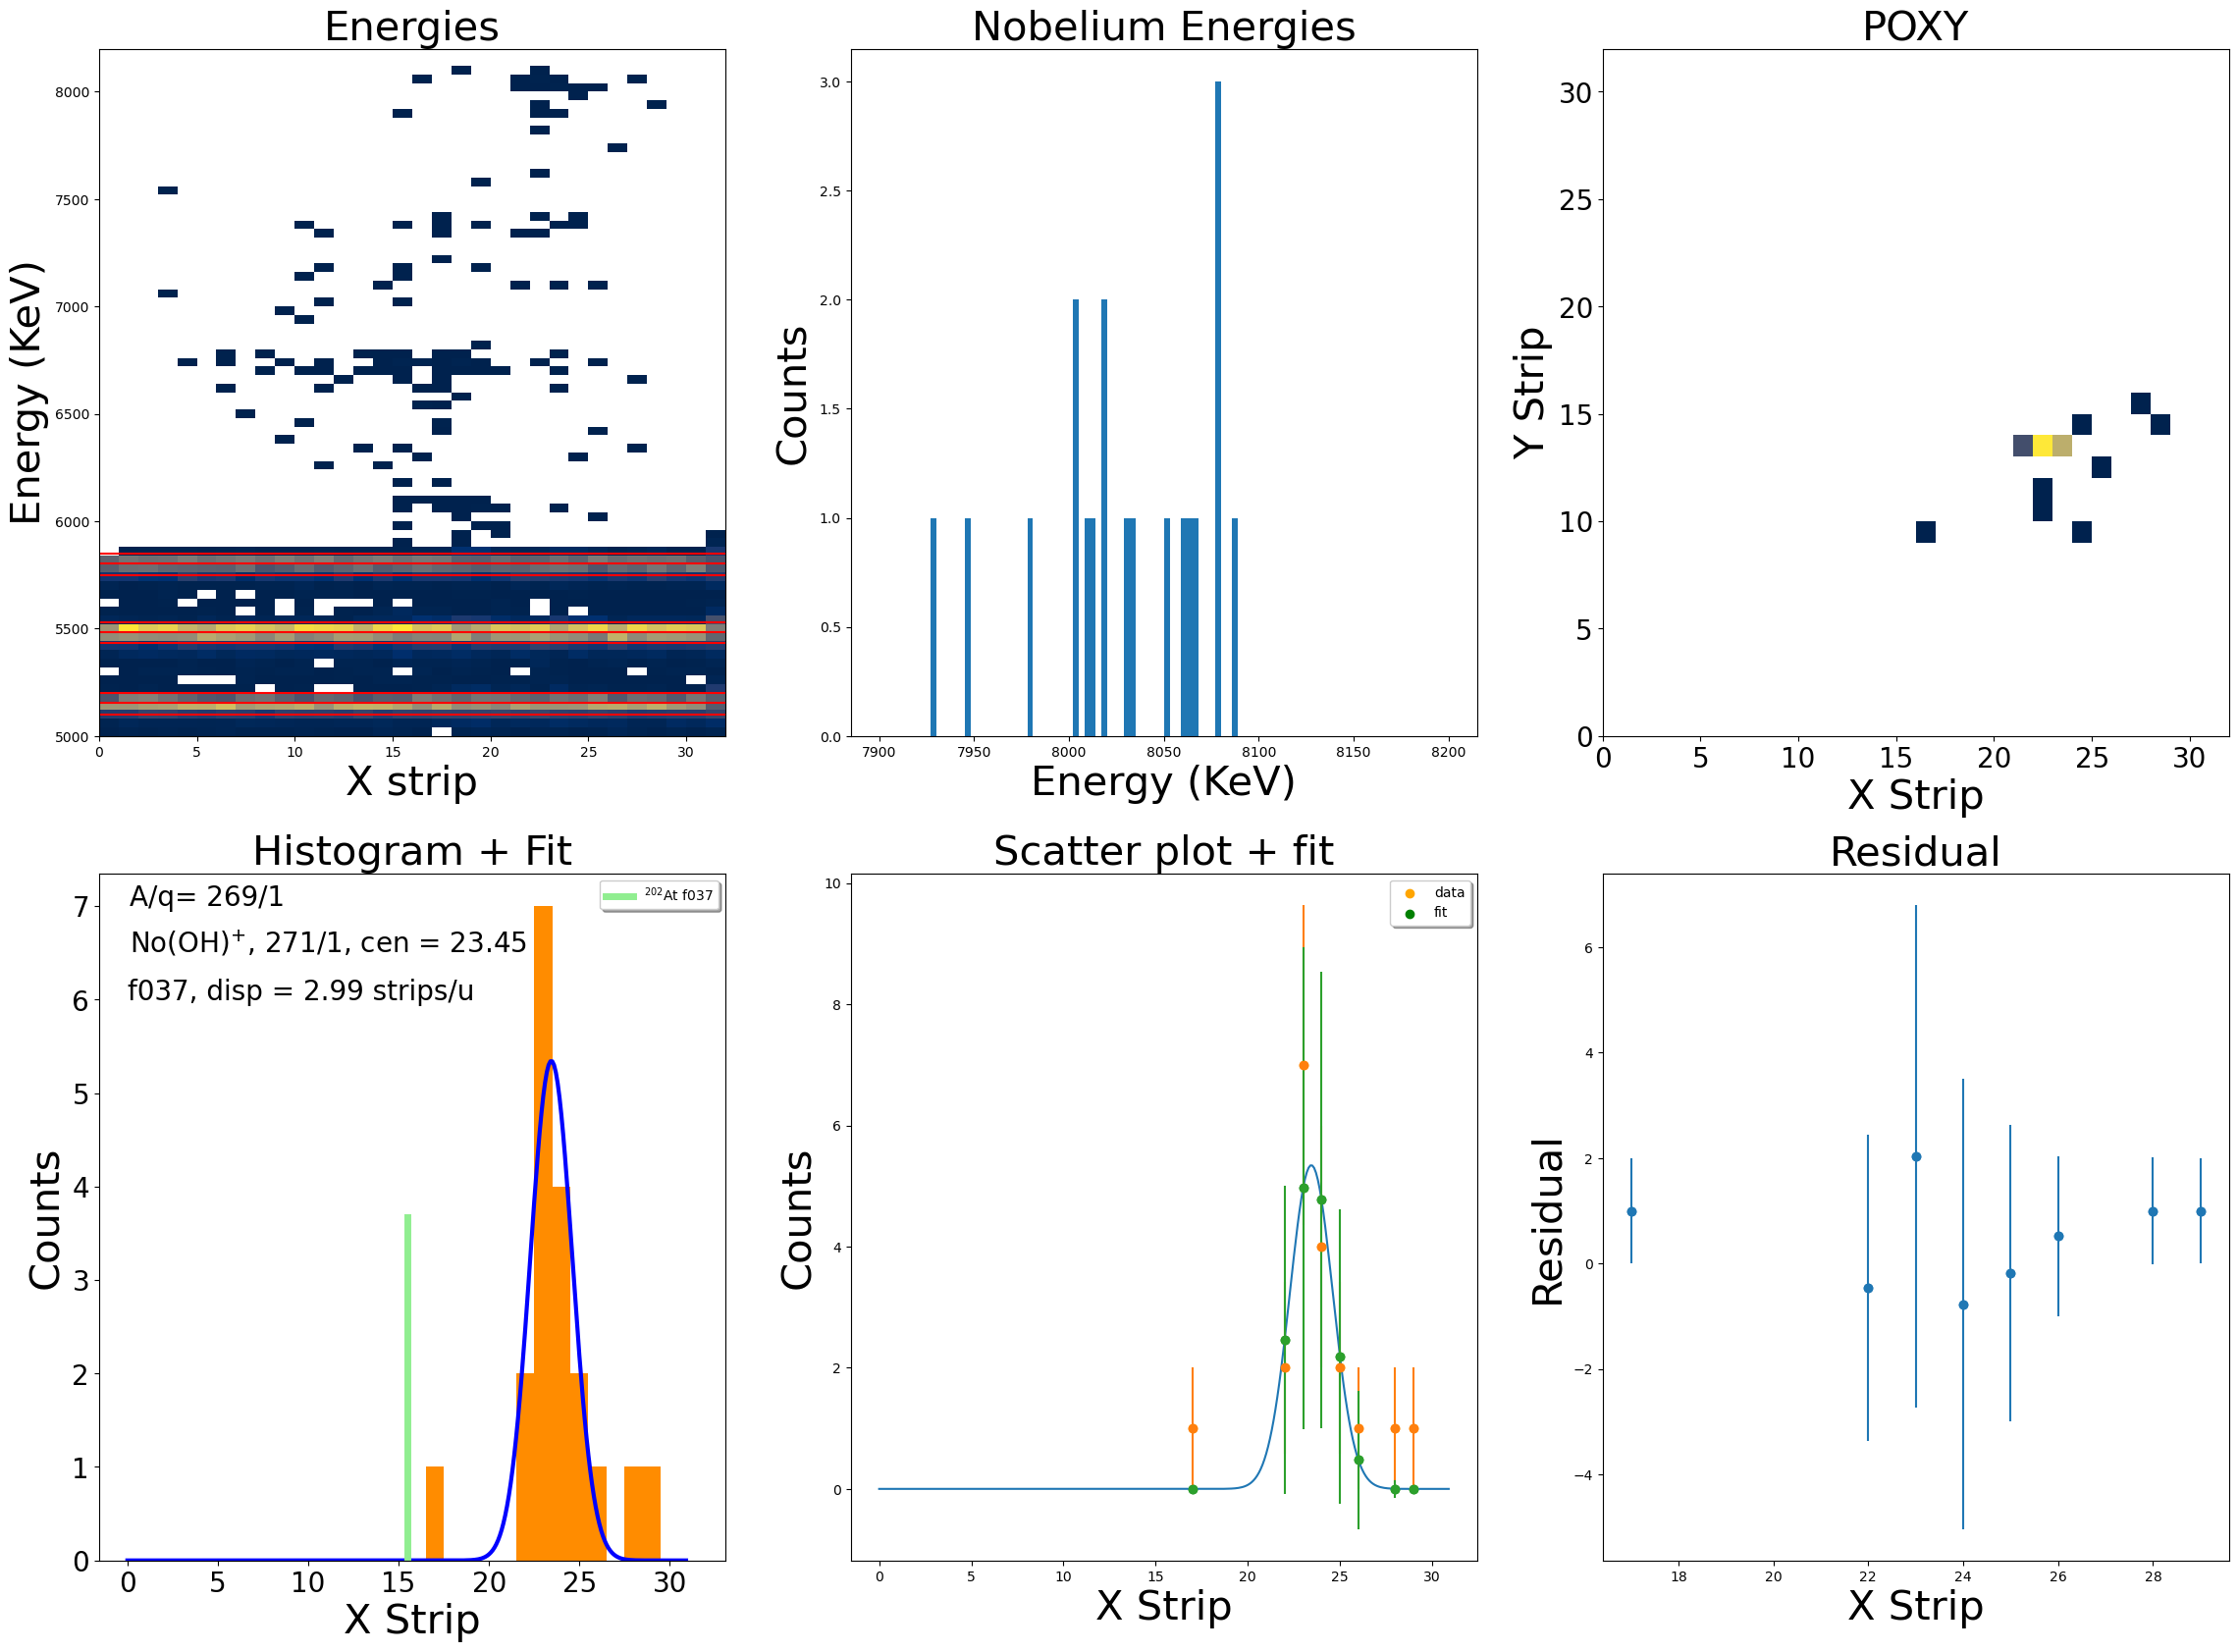

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.133 (chi2/ndof = 0.8)    │              Nfcn = 402              │
│ EDM = 5.54e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [348]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df, t1 = readDS('run231_038_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates = df[(df['y'] >=9) & (df['y'] < 21) & (df['xE'] > 7900) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram and fit
counts,bins = np.histogram(gates['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,onepeak)
m= minuit.Minuit(c,7,25,1)
m.limits=((0,None), (23,30),(0,2))
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
yy= onepeak(bins_,amp_1,cen_1,exp_1)
yy_=onepeak(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.hist(gates['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,6.5,  "No(OH)$^{+}$, 271/1, cen = 23.45", fontsize = 20)
plt.text(.1,7, "A/q= 269/1", fontsize = 20)
plt.text(.01,6, "f037, disp = 2.99 strips/u", fontsize = 20)



### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [onepeak_error(newBins_change, p) for p in par_b]
error = np.sqrt(m.fval)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)



### scatter plot with fit
plt.subplot(2,3,5)
plt.plot(bins_,yy)
c_= np.sqrt(newcounts)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")
plt.legend(loc='upper right', shadow=True)



### Residual

residual = (newcounts - yy_)
plt.subplot(2,3,6)
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual)
plt.errorbar(newBins_change,residual, yerr=reserror, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual',fontsize = 30)

plt.show()

### How many counts in peak, area of the peak
area1=amp_1*exp_1/.3989

### print m. values
print (m.migrad())


### Rutherford Number, East
dfR, t1R = readRuth('run231_038_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfR)))

### CPR
CPR = area1/len(dfR)*1000
print(" Counts per 1k ruth ? = %0.10f" % (CPR))



### f039, 269/1, No Methide, with gas

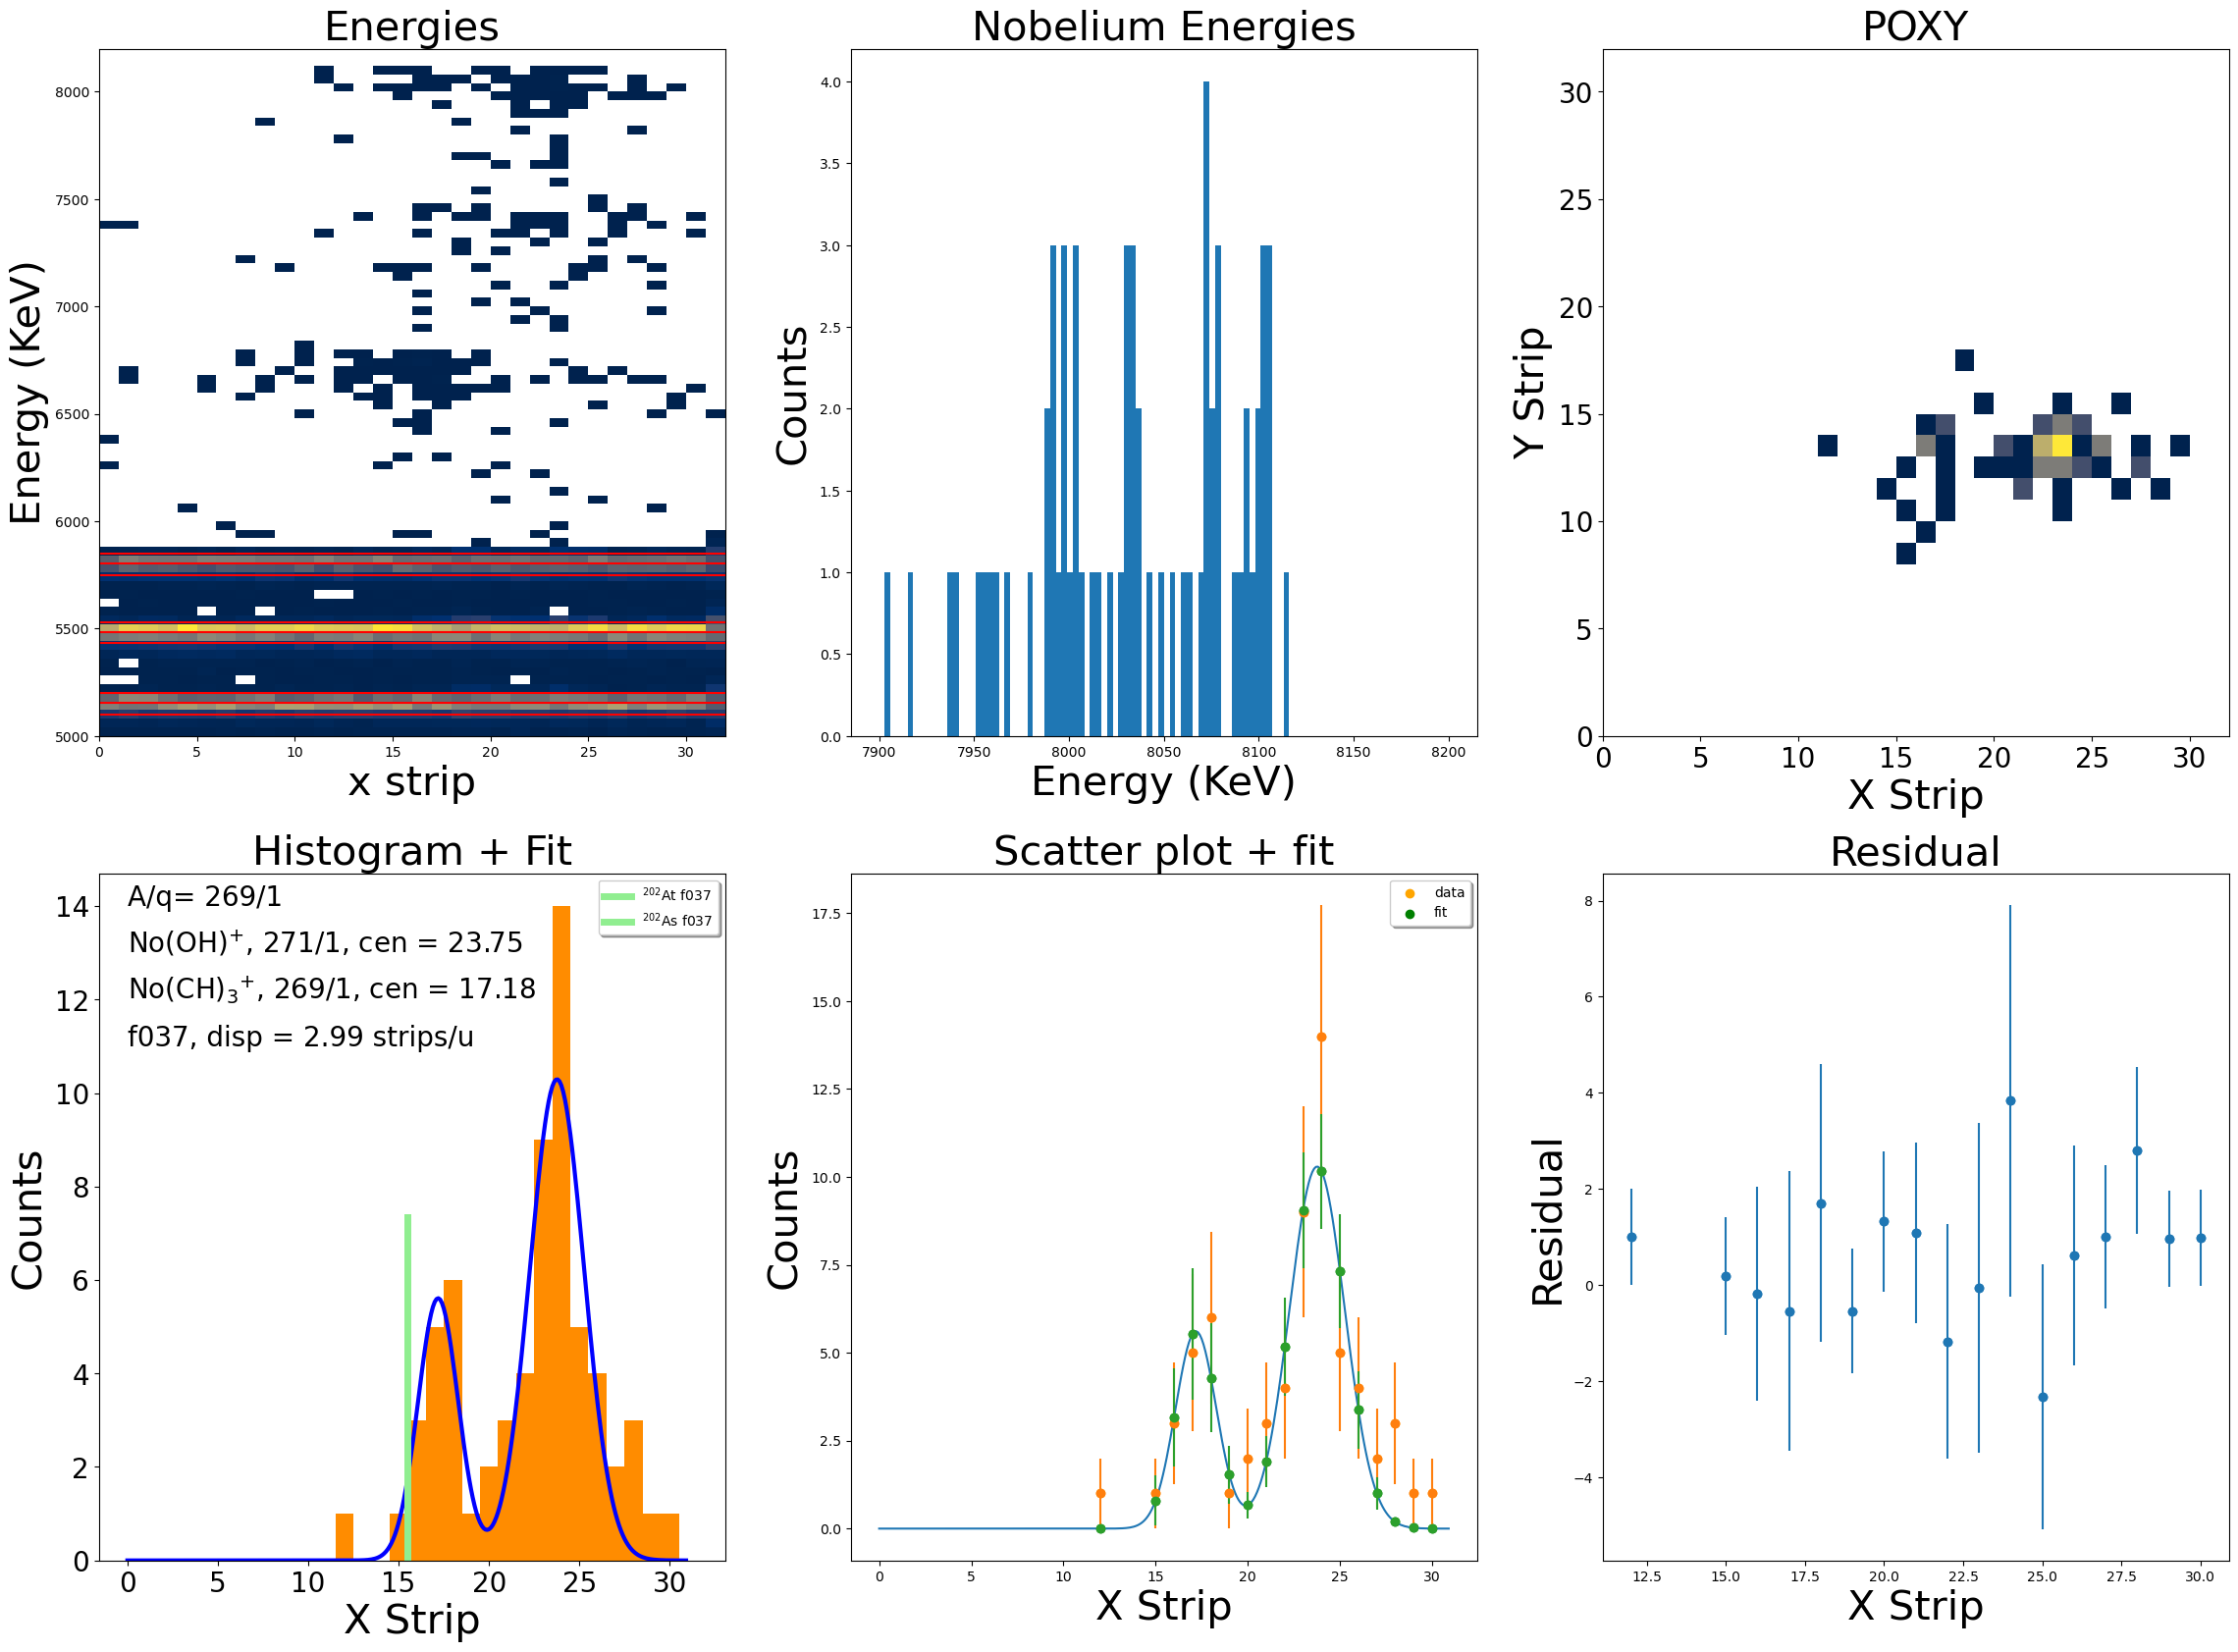

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.81 (chi2/ndof = 1.0)    │              Nfcn = 260              │
│ EDM = 2.29e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [349]:

cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)


df2_1, t2_1 = readDS('run231_039_output.txt', cal)
df2_2, t2_2 = readDS('run231_039_2_output.txt', cal)
df2 = pd.concat([df1_1,df1_2])


### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df2['x'], df2['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_2 = df2[(df2['y'] >=8) & (df2['y'] < 18) & (df2['xE'] > 7900) & (df2['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_2['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY
plt.subplot(2,3,3)
plt.hist2d(gates_2['x'], gates_2['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram and fit
counts,bins = np.histogram(gates_2['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,twopeaks)
m= minuit.Minuit(c,6,16,1,14,25,1.2)
m.limits = [(None,None),(None,None),(0,1.5),(0,None), (0, None),(0,1.5)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
yy= twopeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_2['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.text(0.01,13, "No(OH)$^{+}$, 271/1, cen = 23.75", fontsize = 20)
plt.text(.01,14, "A/q= 269/1", fontsize = 20)
plt.text(0.01,12, "No(CH)$_3$$^{+}$, 269/1, cen = 17.18", fontsize = 20)
plt.text(.01,11, "f037, disp = 2.99 strips/u", fontsize = 20)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)





### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [twopeaks_error(newBins_change, p) for p in par_b]
error = 1*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)



### scatter plot with fit
plt.subplot(2,3,5)
plt.plot(bins_,yy)
c_= np.sqrt(newcounts)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")
plt.legend(loc='upper right', shadow=True)



### Residual

residual = (newcounts - yy_)
plt.subplot(2,3,6)
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual)
plt.errorbar(newBins_change,residual, yerr=reserror, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual',fontsize = 30)


plt.show()
### How many counts in peak, area of the peak
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989




print (m.migrad())

### Rutherford Number, East
dfRuth_2_0, t1Ruth_2_0 = readRuth('run231_039_output_Ruth.txt', 'ruthE')
dfRuth_2_1, t1Ruth_2_1 = readRuth('run231_039_2_output_Ruth.txt', 'ruthE')
dfRuth_2 = pd.concat([dfRuth_2_0,dfRuth_2_1])
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_2)))

### Counts per 1k ruth (CPR)
CPR_Methide = area1/len(dfRuth_2)*1000
CPR_OH = area2/len(dfRuth_2)*1000

print(" Counts per 1k ruth (CPR_Methide)= %0.10f" % (CPR_Methide))
print(" Counts per 1k ruth (CPR_OH)= %0.10f" % (CPR_OH))






### f071, Looking for NoC$_{4}$H$_{8}$$^{2+}$, A/q= 310/2, with gas

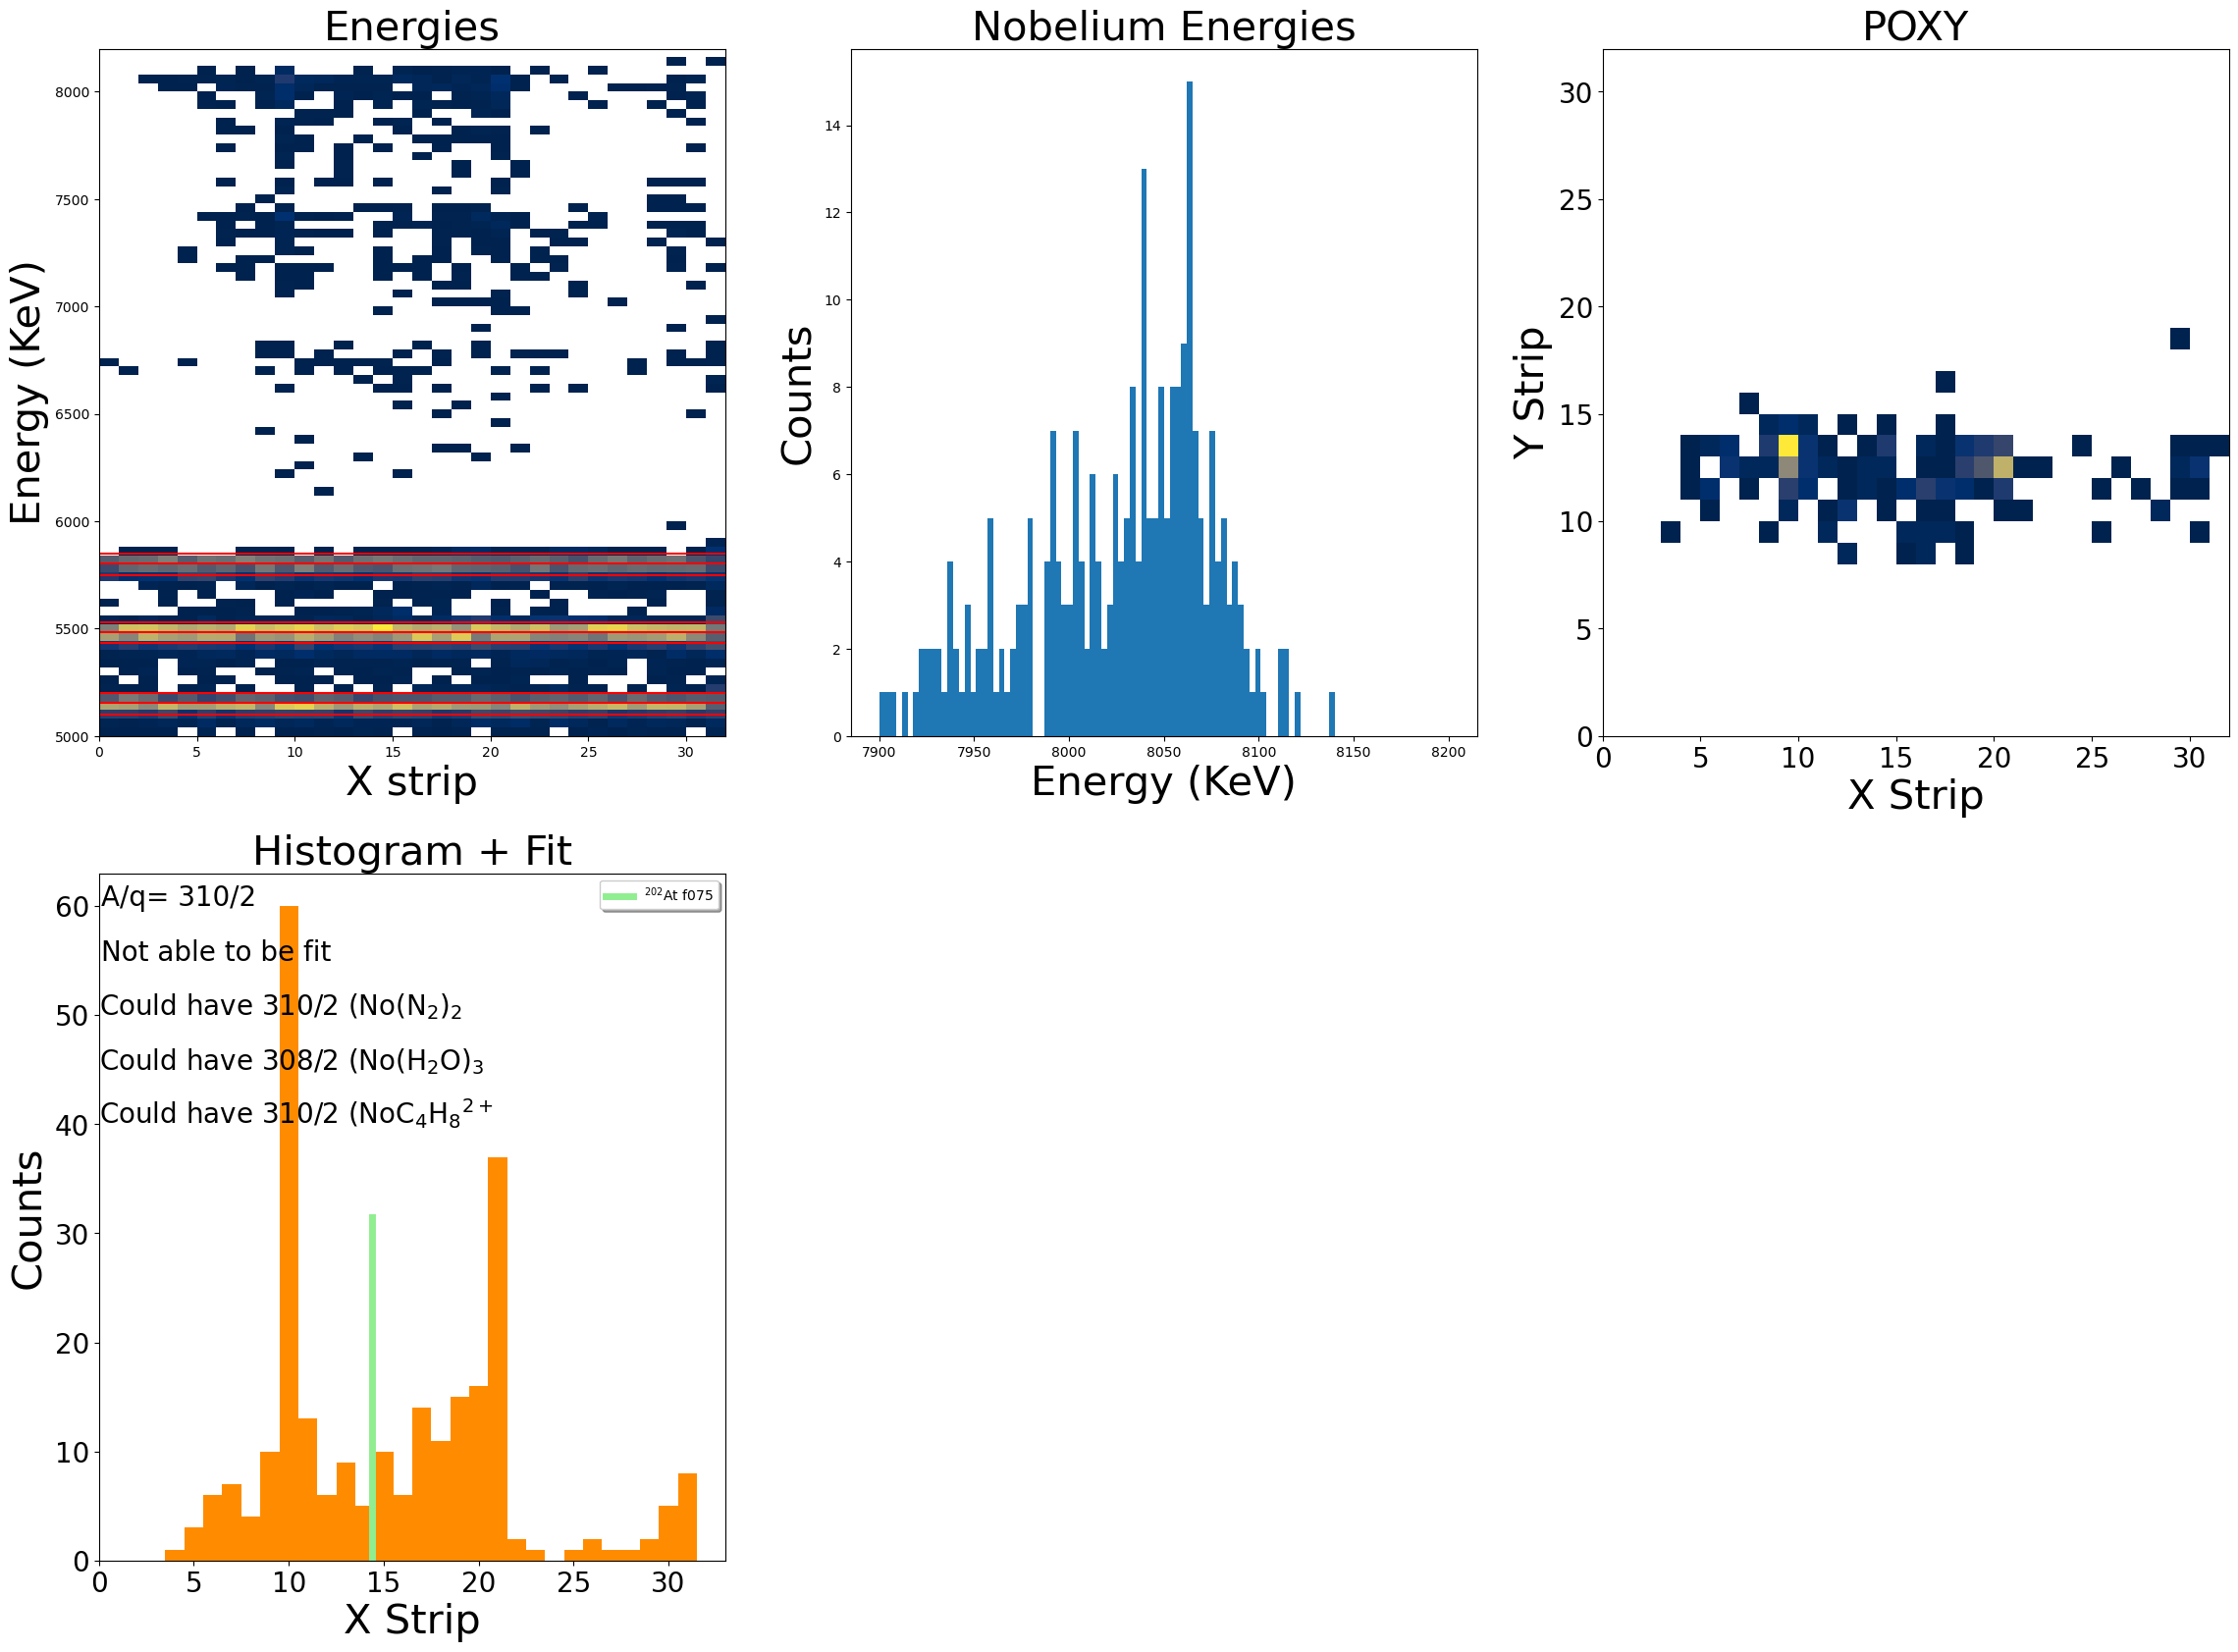

In [371]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)

df_p2, t1_p2 = readDS('run231_071_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df_p2['x'], df_p2['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_p2 = df_p2[(df_p2['y'] >=8) & (df_p2['y'] < 21) & (df_p2['xE'] > 7900) & (df_p2['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_p2['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_p2['x'], gates_p2['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_p2['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_p2['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,55,  "Not able to be fit", fontsize = 20)
plt.text(.1,60, "A/q= 310/2", fontsize = 20)
plt.text(.01,50, "Could have 310/2 (No(N$_{2}$)$_{2}$", fontsize = 20)
plt.text(.01,45, "Could have 308/2 (No(H$_{2}$O)$_{3}$", fontsize = 20)
plt.text(.01,40, "Could have 310/2 (NoC$_{4}$H$_{8}$$^{2+}$", fontsize = 20)
plt.axvline(14.41,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f075')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)




plt.show()




## 269/2, f065, with butane gas, proving methide is not coming in as a 2+

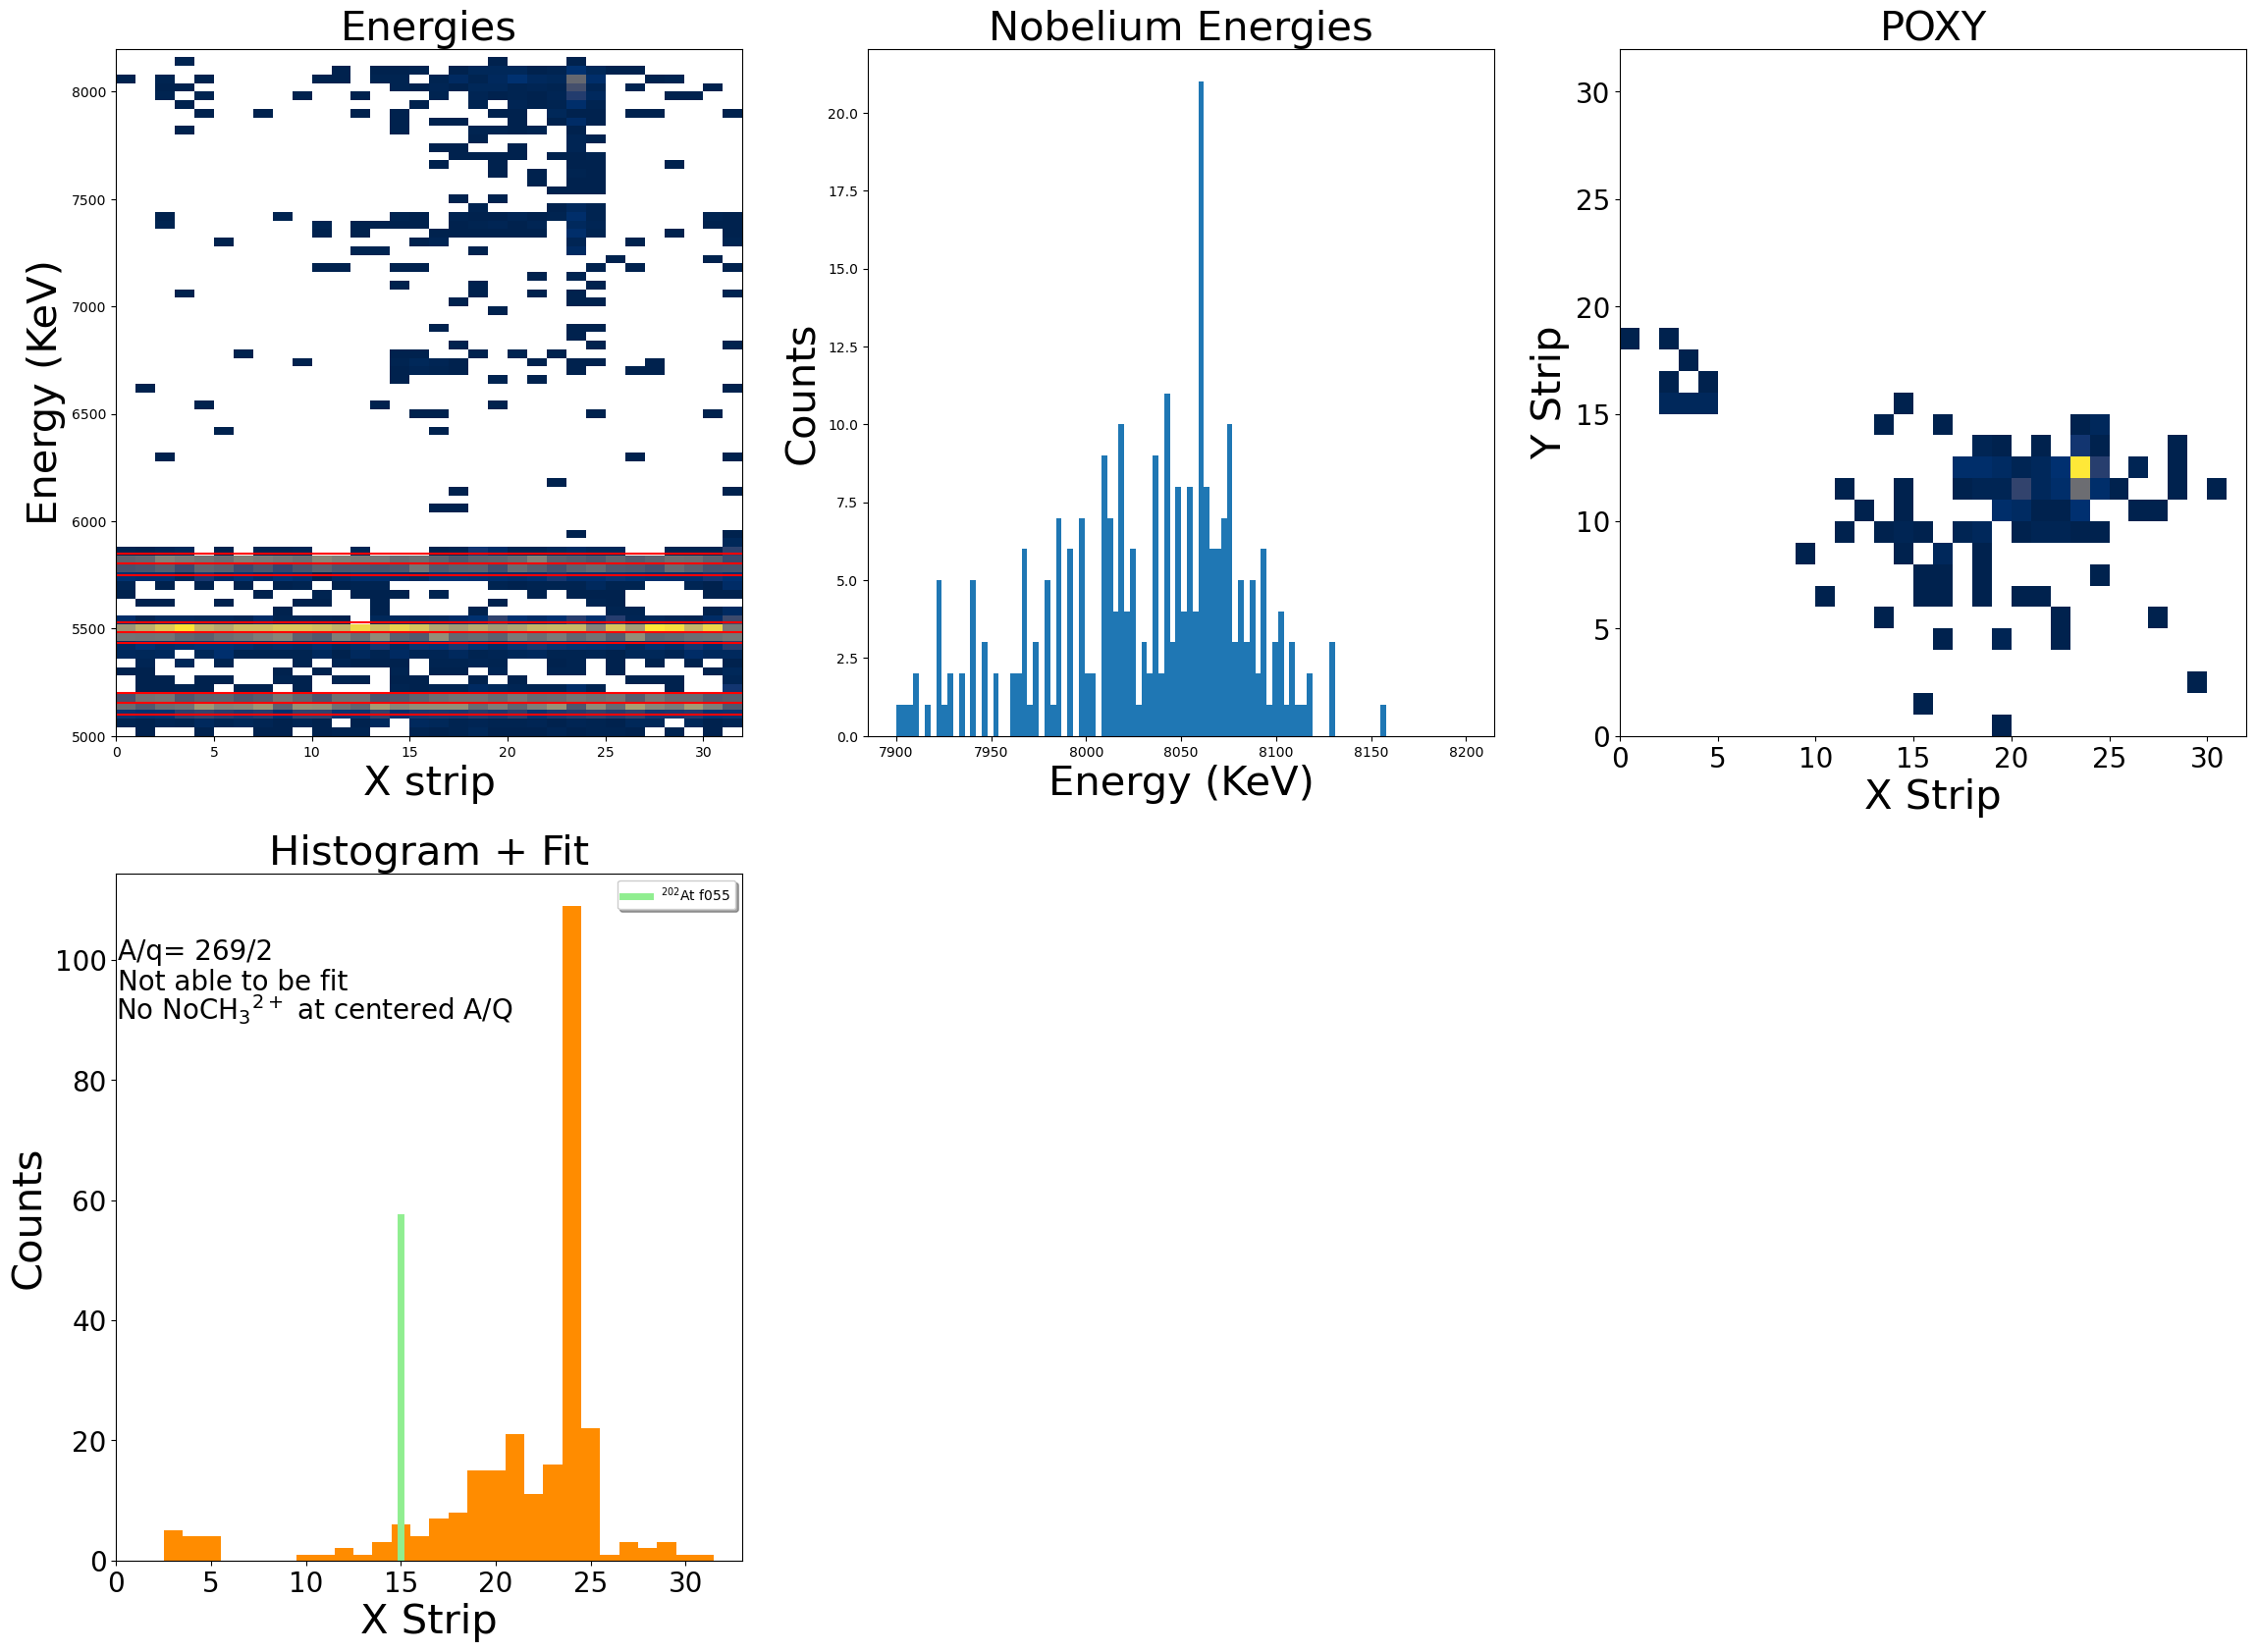

In [375]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df_p3, t1_p3 = readDS('run231_065_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df_p3['x'], df_p3['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_p3 = df_p3[(df_p3['y'] >=0) & (df_p3['y'] < 31) & (df_p3['xE'] > 7900) & (df_p3['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_p3['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_p3['x'], gates_p3['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_p3['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_p3['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,95,  "Not able to be fit", fontsize = 20)
plt.text(.1,100, "A/q= 269/2", fontsize = 20)
plt.text(.01,90, "No NoCH$_{3}$$^{2+}$ at centered A/Q", fontsize = 20)
plt.axvline(15,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)




plt.show()




# Flouride

### f035, NoF Baseline, A/q = 273/1, no gas

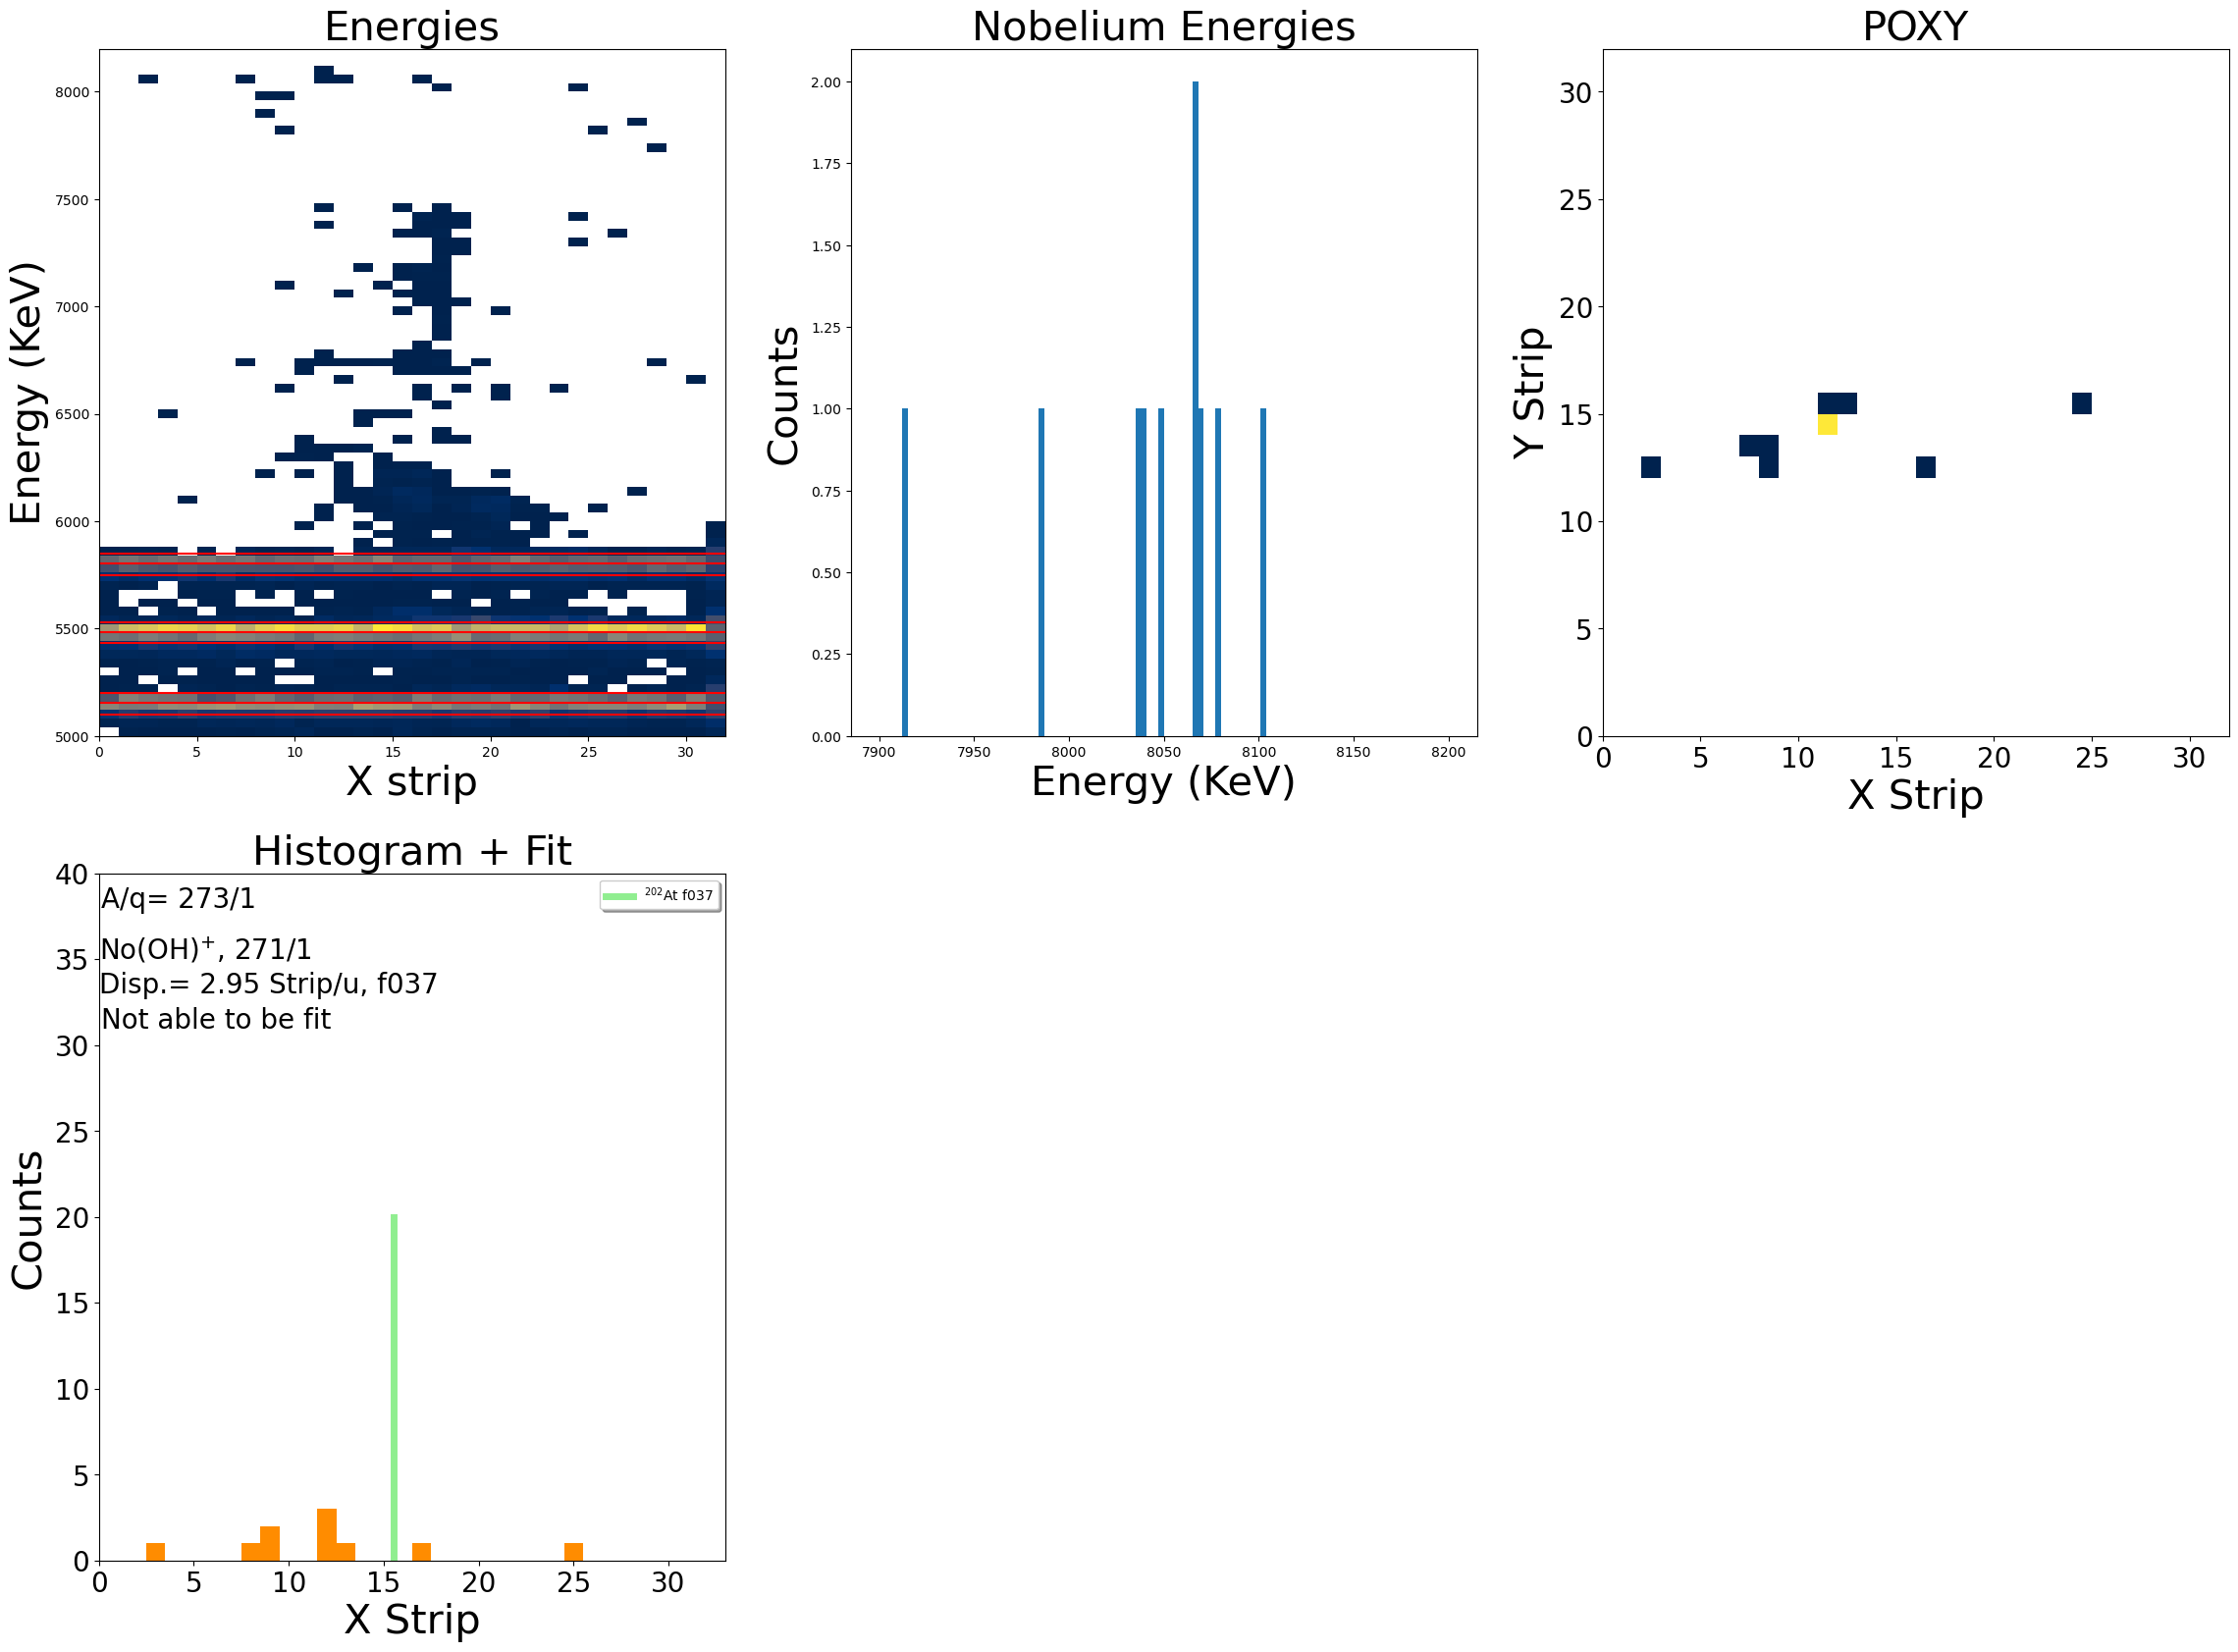

 Number of Rutherfords? = 134457.0000000000
 Counts per 1k ruth ? = 0.0743732197


In [382]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df3, t13 = readDS('run231_035_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df3['x'], df3['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_3= df3[(df3['y'] >=9) & (df3['y'] < 21) & (df3['xE'] > 7900) & (df3['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_3['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_3['x'], gates_3['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram
counts,bins = np.histogram(gates_3['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.hist(gates_3['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.ylim(0,40)
plt.text(0.01,35, "No(OH)$^{+}$, 271/1", fontsize = 20)
plt.text(.1,38, "A/q= 273/1", fontsize = 20)
plt.text(.03,33, "Disp.= 2.95 Strip/u, f037", fontsize = 20)
plt.text(.1,31,  "Not able to be fit", fontsize = 20)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)


plt.show()

### How many counts in peak, area of the peak
area1=sum(newcounts)



### Rutherford Number, East
dfR_3, t1R_3 = readRuth('run231_035_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfR_3)))

### CPR
CPR_3 = area1/len(dfR_3)*1000
print(" Counts per 1k ruth ? = %0.10f" % (CPR_3))



### f036, A/q = 273/1, NoF, with gas

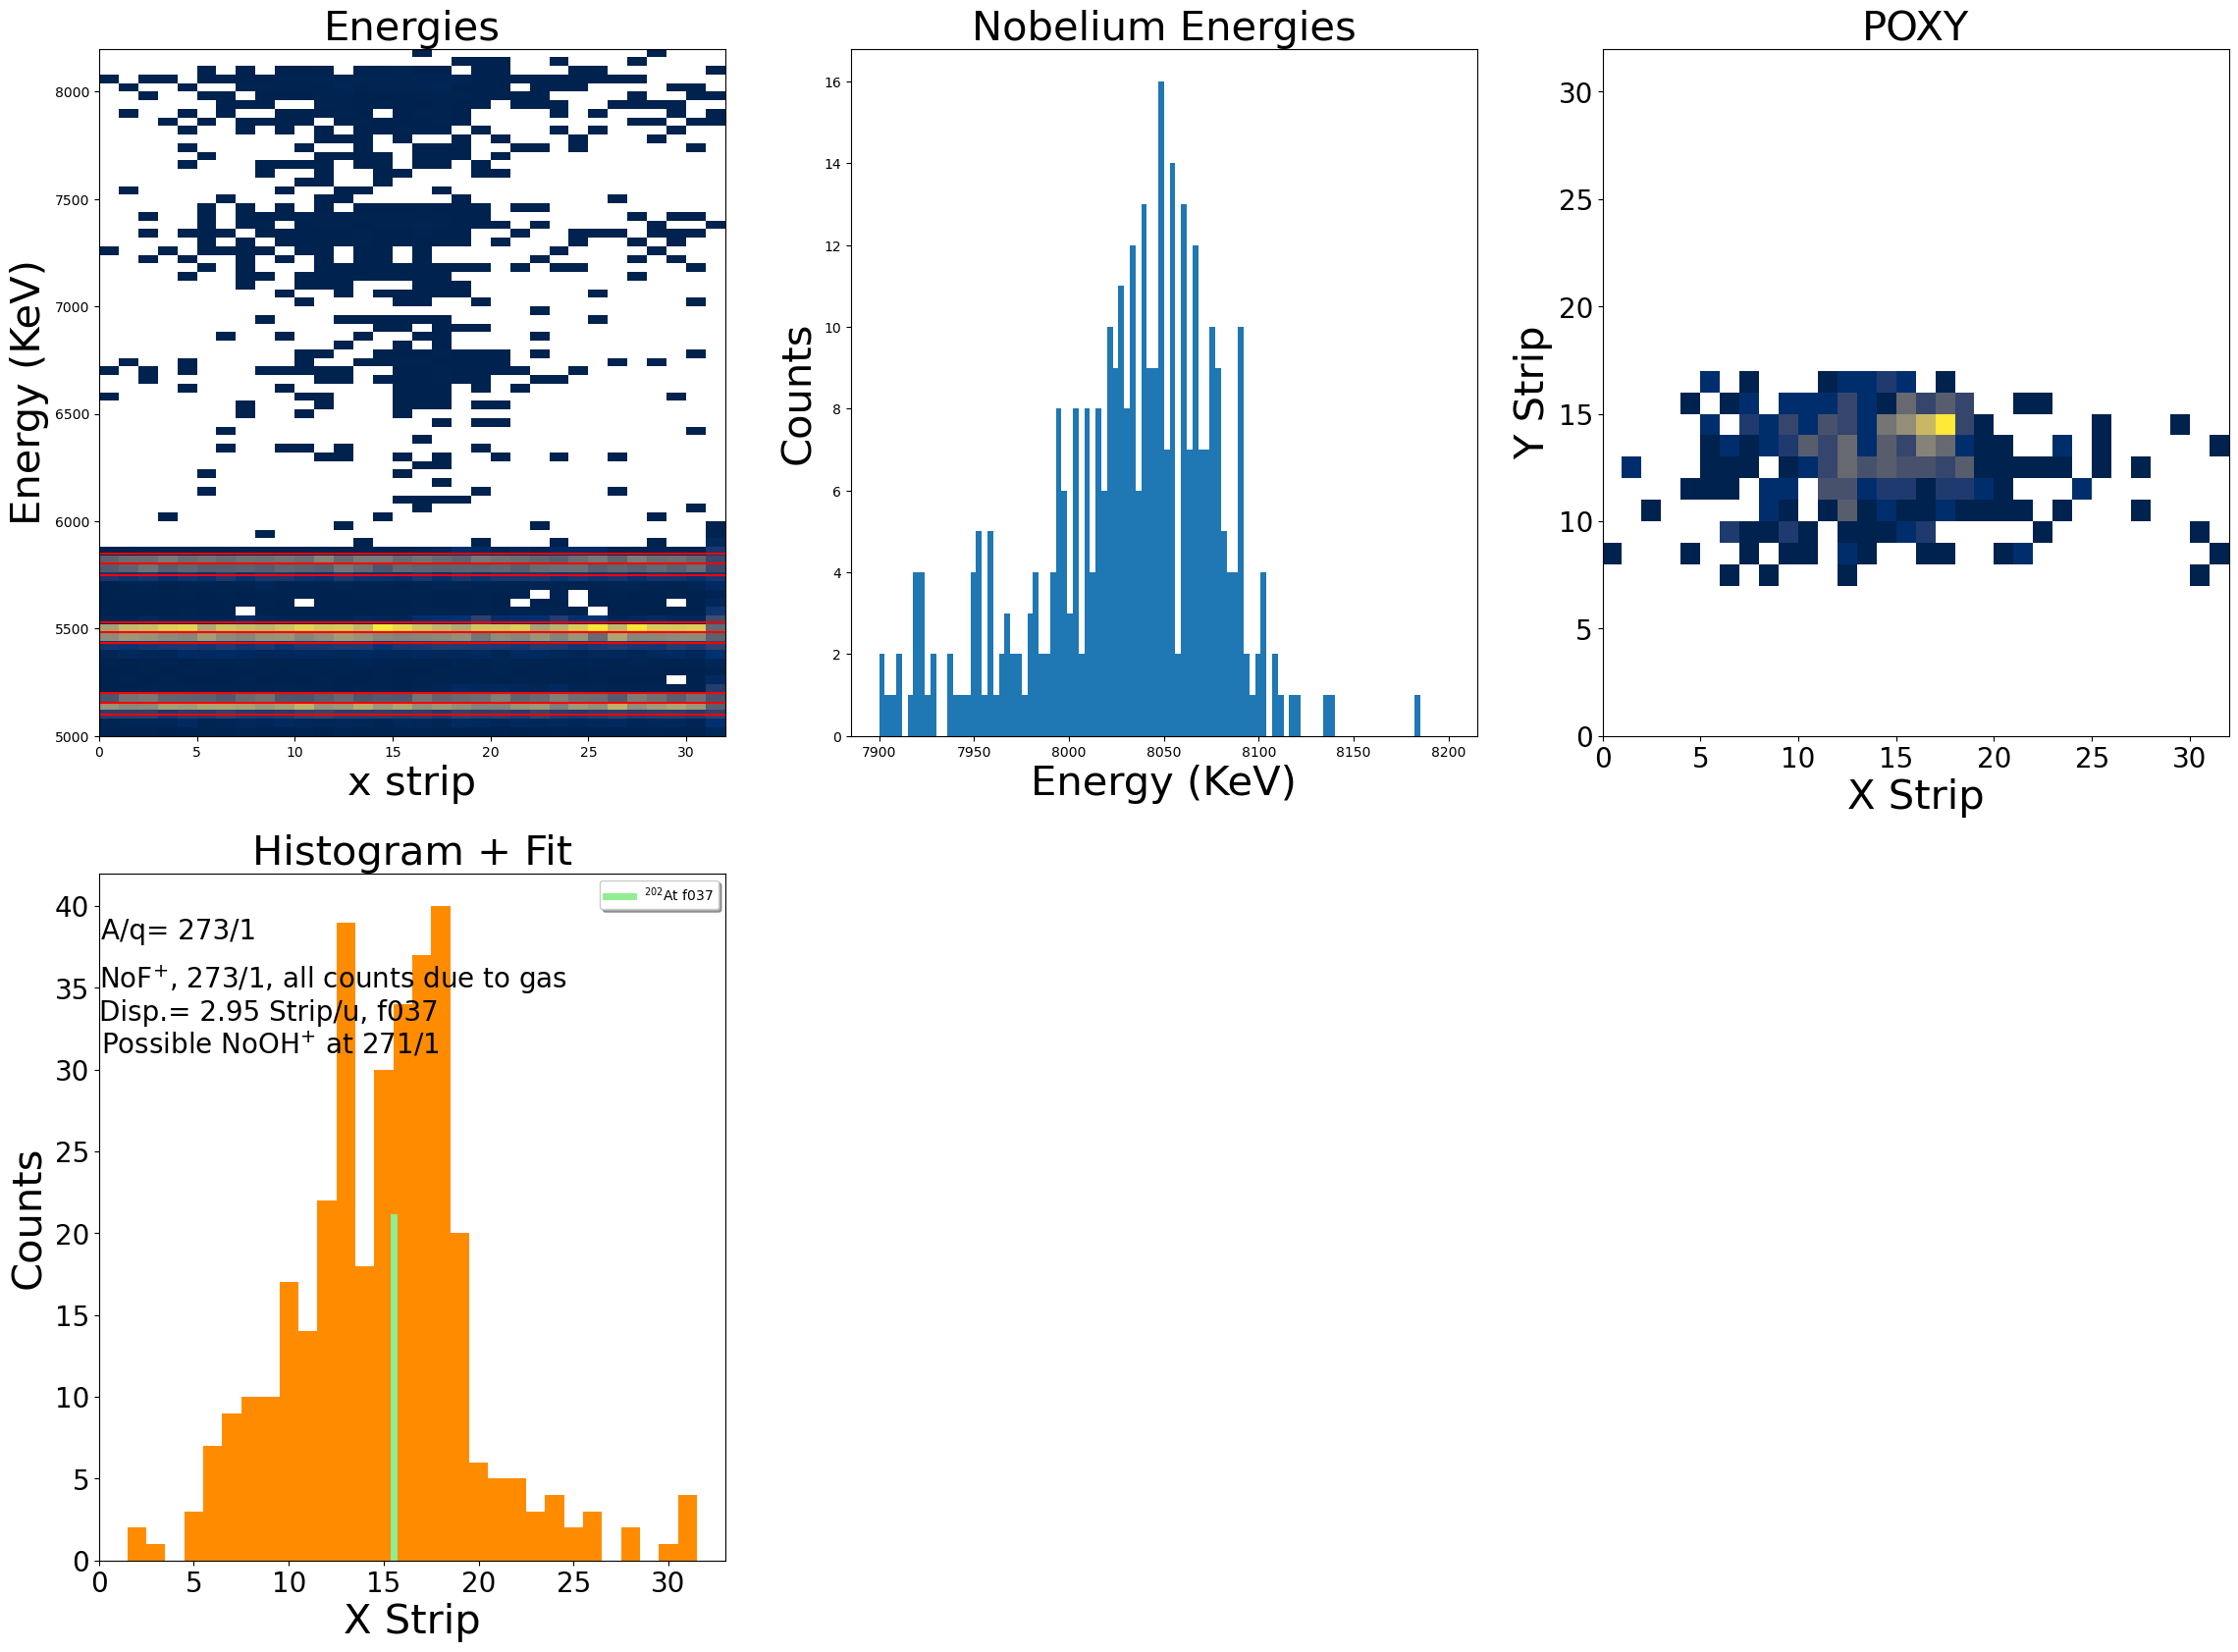

 Number of Rutherfords? = 253523.0000000000
 Counts per 1k ruth  = 1.3766009396


In [381]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
df4_1, t4_1 = readDS('run231_036_output.txt', cal)
df4_2, t4_2 = readDS('run231_036_2_output.txt', cal)

df4 = pd.concat([df4_1,df4_2])


### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df4['x'], df4['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_4 = df4[(df4['y'] >=7) & (df4['y'] < 17) & (df4['xE'] > 7900) & (df4['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_4['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_4['x'], gates_4['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_4['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
yy= twopeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_4['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.text(0.01,35, "NoF$^{+}$, 273/1, all counts due to gas", fontsize = 20)
plt.text(.1,38, "A/q= 273/1", fontsize = 20)
plt.text(.1,31, "Possible NoOH$^{+}$ at 271/1", fontsize = 20)
plt.text(.03,33, "Disp.= 2.95 Strip/u, f037", fontsize = 20)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.show()




### How many counts

area1= sum(newcounts)




### Rutherford Number, East
dfR_4_1, t1R_4_1 = readRuth('run231_036_output_Ruth.txt', 'ruthE')
dfR_4_2, t1R_4_2 = readRuth('run231_036_2_output_Ruth.txt', 'ruthE')
dfR_4 = pd.concat([dfR_4_1,dfR_4_2])

print(" Number of Rutherfords? = %0.10f" % (len(dfR_4)))

### CPR
CPR_4 = area1/len(dfR_4)*1000



print(" Counts per 1k ruth  = %0.10f" % (CPR_4))




# Using 290/1 as a baseline

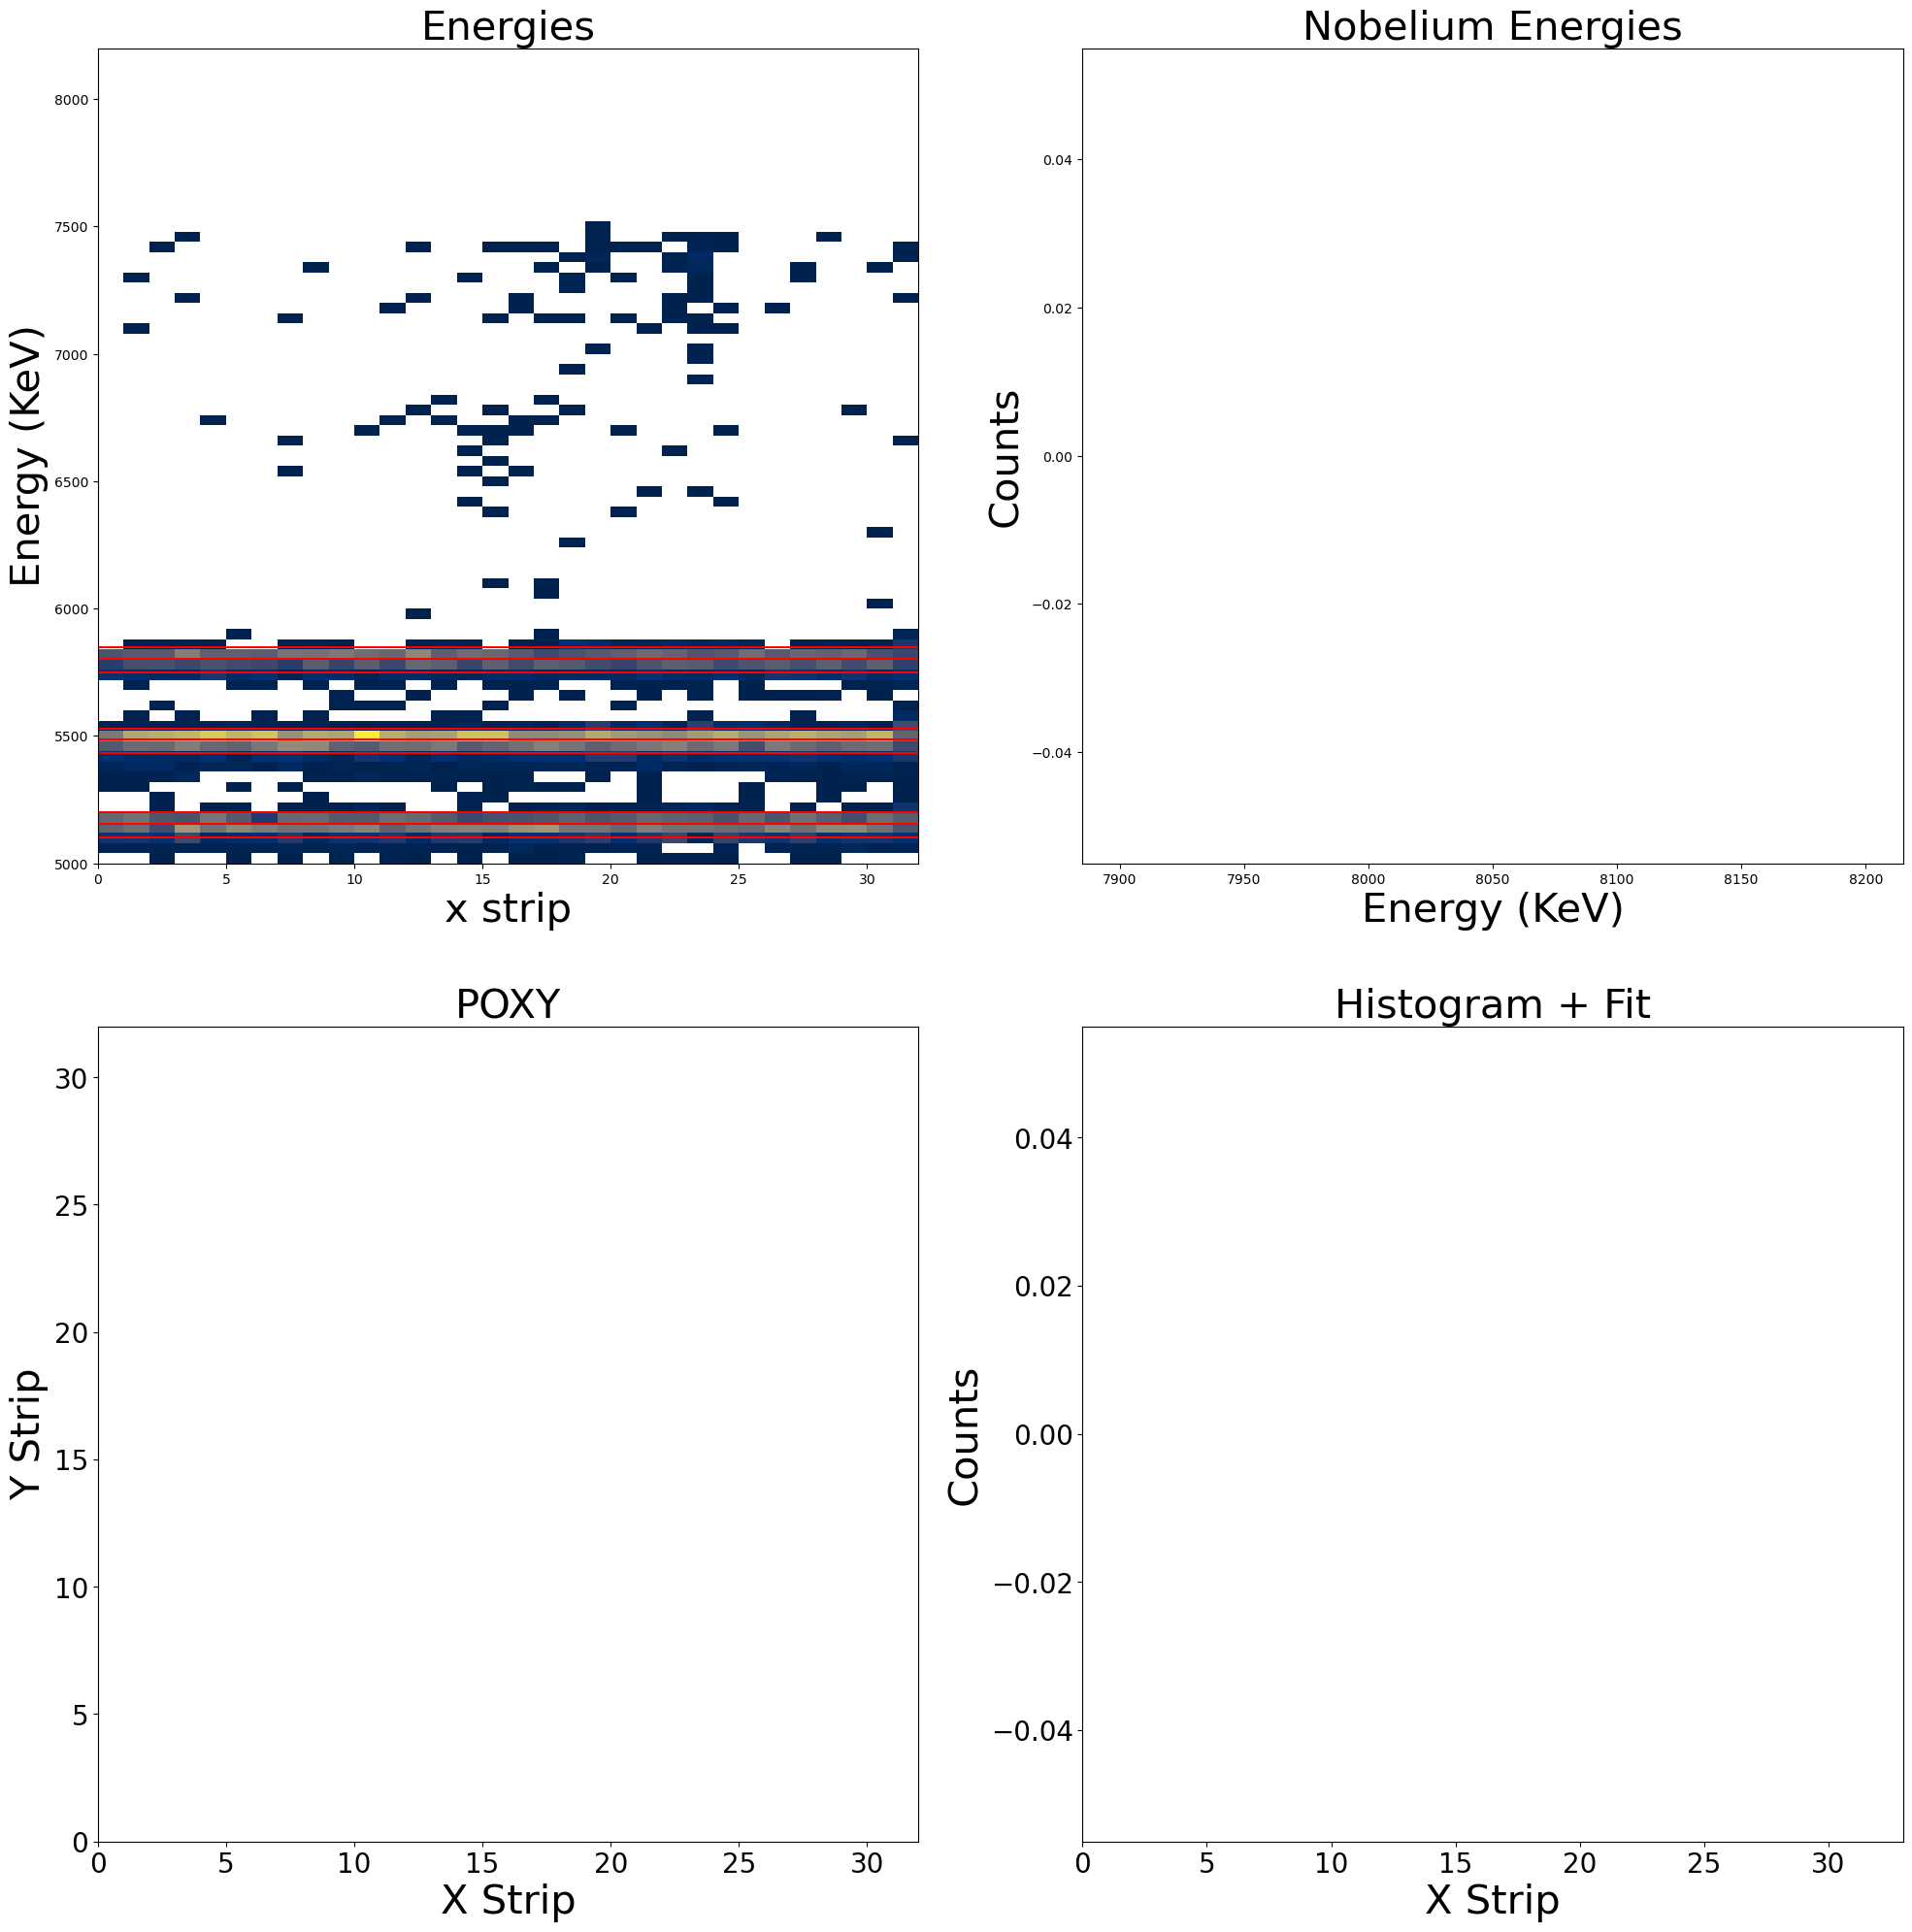

In [380]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)
df5, t5 = readDS('run231_066_output.txt', cal)



### checking the energies
plt.figure(figsize = (24,24))
plt.axes().set_aspect('equal')
plt.subplot(2,2,1)
plt.hist2d(df5['x'], df5['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_5 = df5[(df5['y'] >=0) & (df5['y'] < 31) & (df5['xE'] > 7900) & (df5['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,2,2)
plt.hist(gates_5['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,2,3)
plt.hist2d(gates_5['x'], gates_5['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_5['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
yy= twopeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.subplot(2,2,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_5['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.show()






### f078,  No$F_{2}$, 292/1

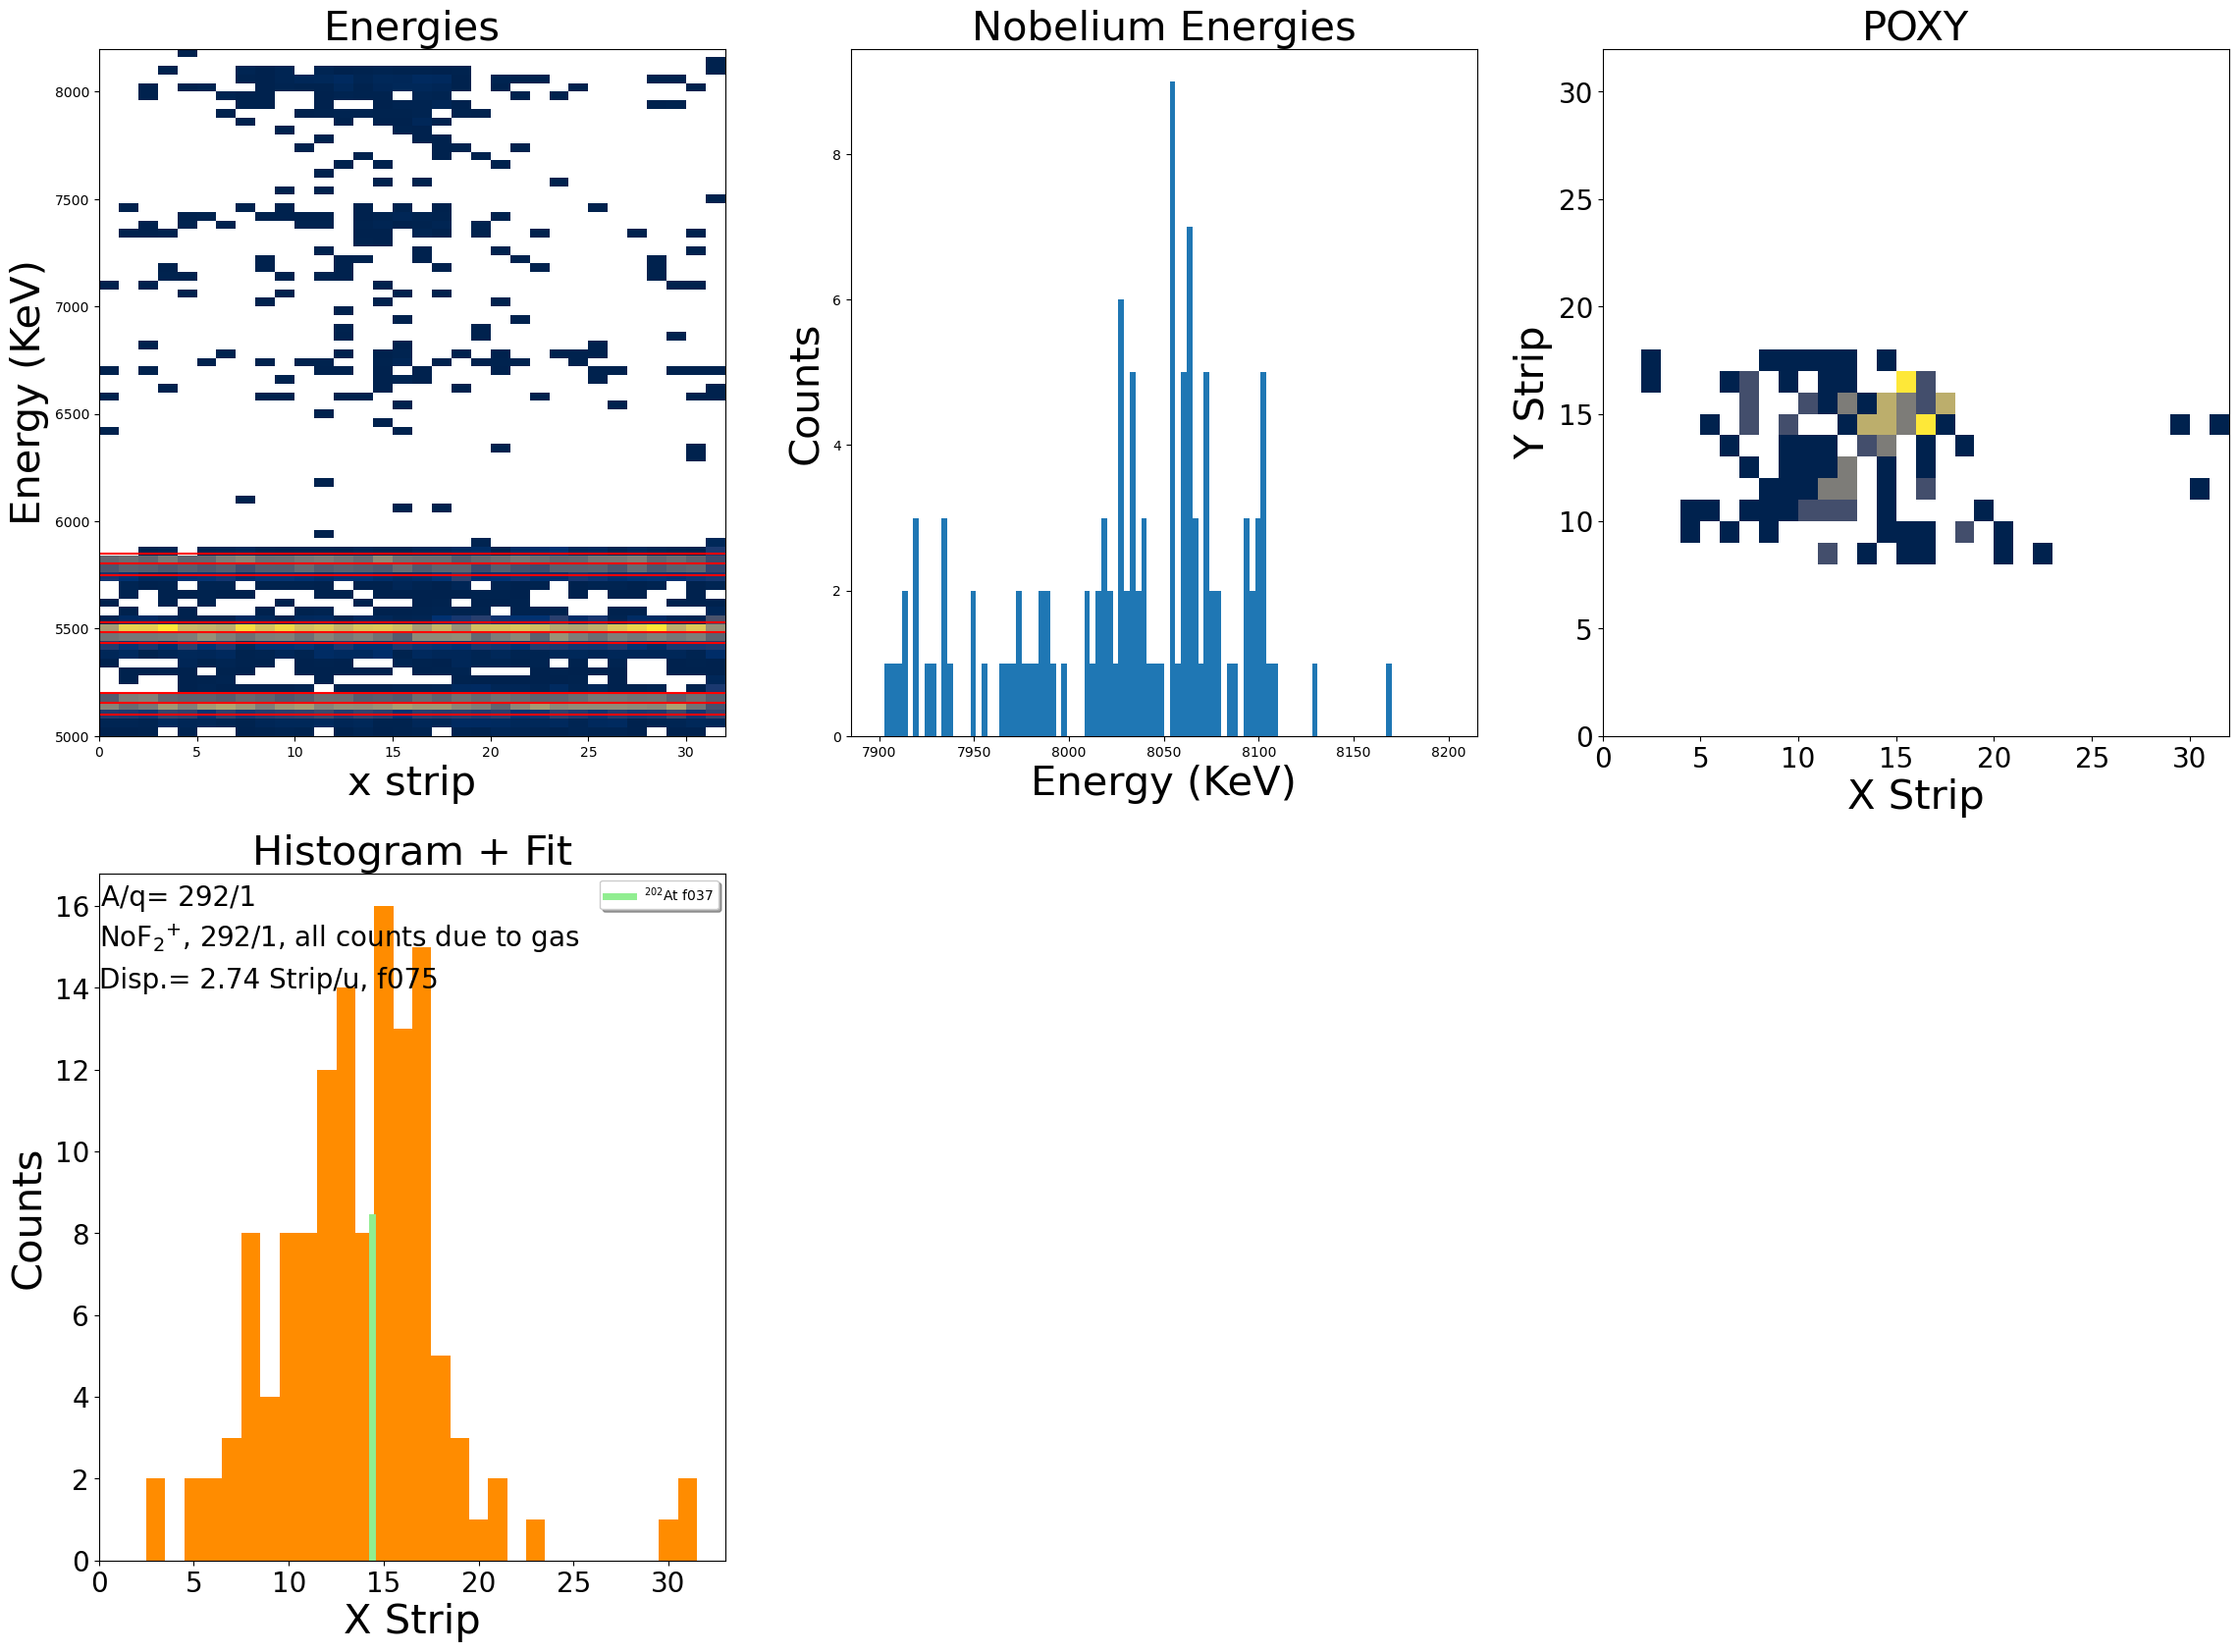

(                    name    det            t   evt_num  Ruth
0      r231f078_4888.lmd  ruthe   458.702458  43521796   890
1      r231f078_4888.lmd  ruthe   485.198567  43523731  2235
2      r231f078_4888.lmd  ruthe   485.250389  43523736  2140
3      r231f078_4888.lmd  ruthe   485.389690  43523756  2254
4      r231f078_4888.lmd  ruthe   485.476259  43523768  2233
...                  ...    ...          ...       ...   ...
62757  r231f078_4888.lmd  ruthe  7269.804919  44171238  2244
62758  r231f078_4888.lmd  ruthe  7270.211399  44171282   985
62759  r231f078_4888.lmd  ruthe  7270.453763  44171308  2214
62760  r231f078_4888.lmd  ruthe  7270.537340  44171317  2279
62761  r231f078_4888.lmd  ruthe  7270.733188  44171338   802

[62762 rows x 5 columns], Timestamp('2020-03-28 05:55:14'))
 Number of Rutherfords? = 62762.0000000000
 Counts per 1k ruth ? = 2.0713170390


In [379]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)
df6, t6 = readDS('run231_078_output.txt', cal)



### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df6['x'], df6['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_6 = df6[(df6['y'] >=8) & (df6['y'] < 18) & (df6['xE'] > 7800) & (df6['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_6['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_6['x'], gates_6['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_6['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_6['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(0.01,15, "NoF$_{2}$$^{+}$, 292/1, all counts due to gas", fontsize = 20)
plt.text(.1,16, "A/q= 292/1", fontsize = 20)
plt.text(.03,14, "Disp.= 2.74 Strip/u, f075", fontsize = 20)
plt.axvline(14.4,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.show()



area1= sum(newcounts)




### Rutherford Number, East
dfR_6 = readRuth('run231_078_output_Ruth.txt', 'ruthE')

print (dfR_6)
### something is wrong with the file, had to print the dataframe to get the number of rutherfords
#62762
print(" Number of Rutherfords? = %0.10f" % 62762)

### CPR
CPR_6 = area1/62762*1000



print(" Counts per 1k ruth ? = %0.10f" % (CPR_6))





## f081, NoF$^{2+}$, proving it is not coming in as a +2. CHECK CUZ MAYBE WE DO?

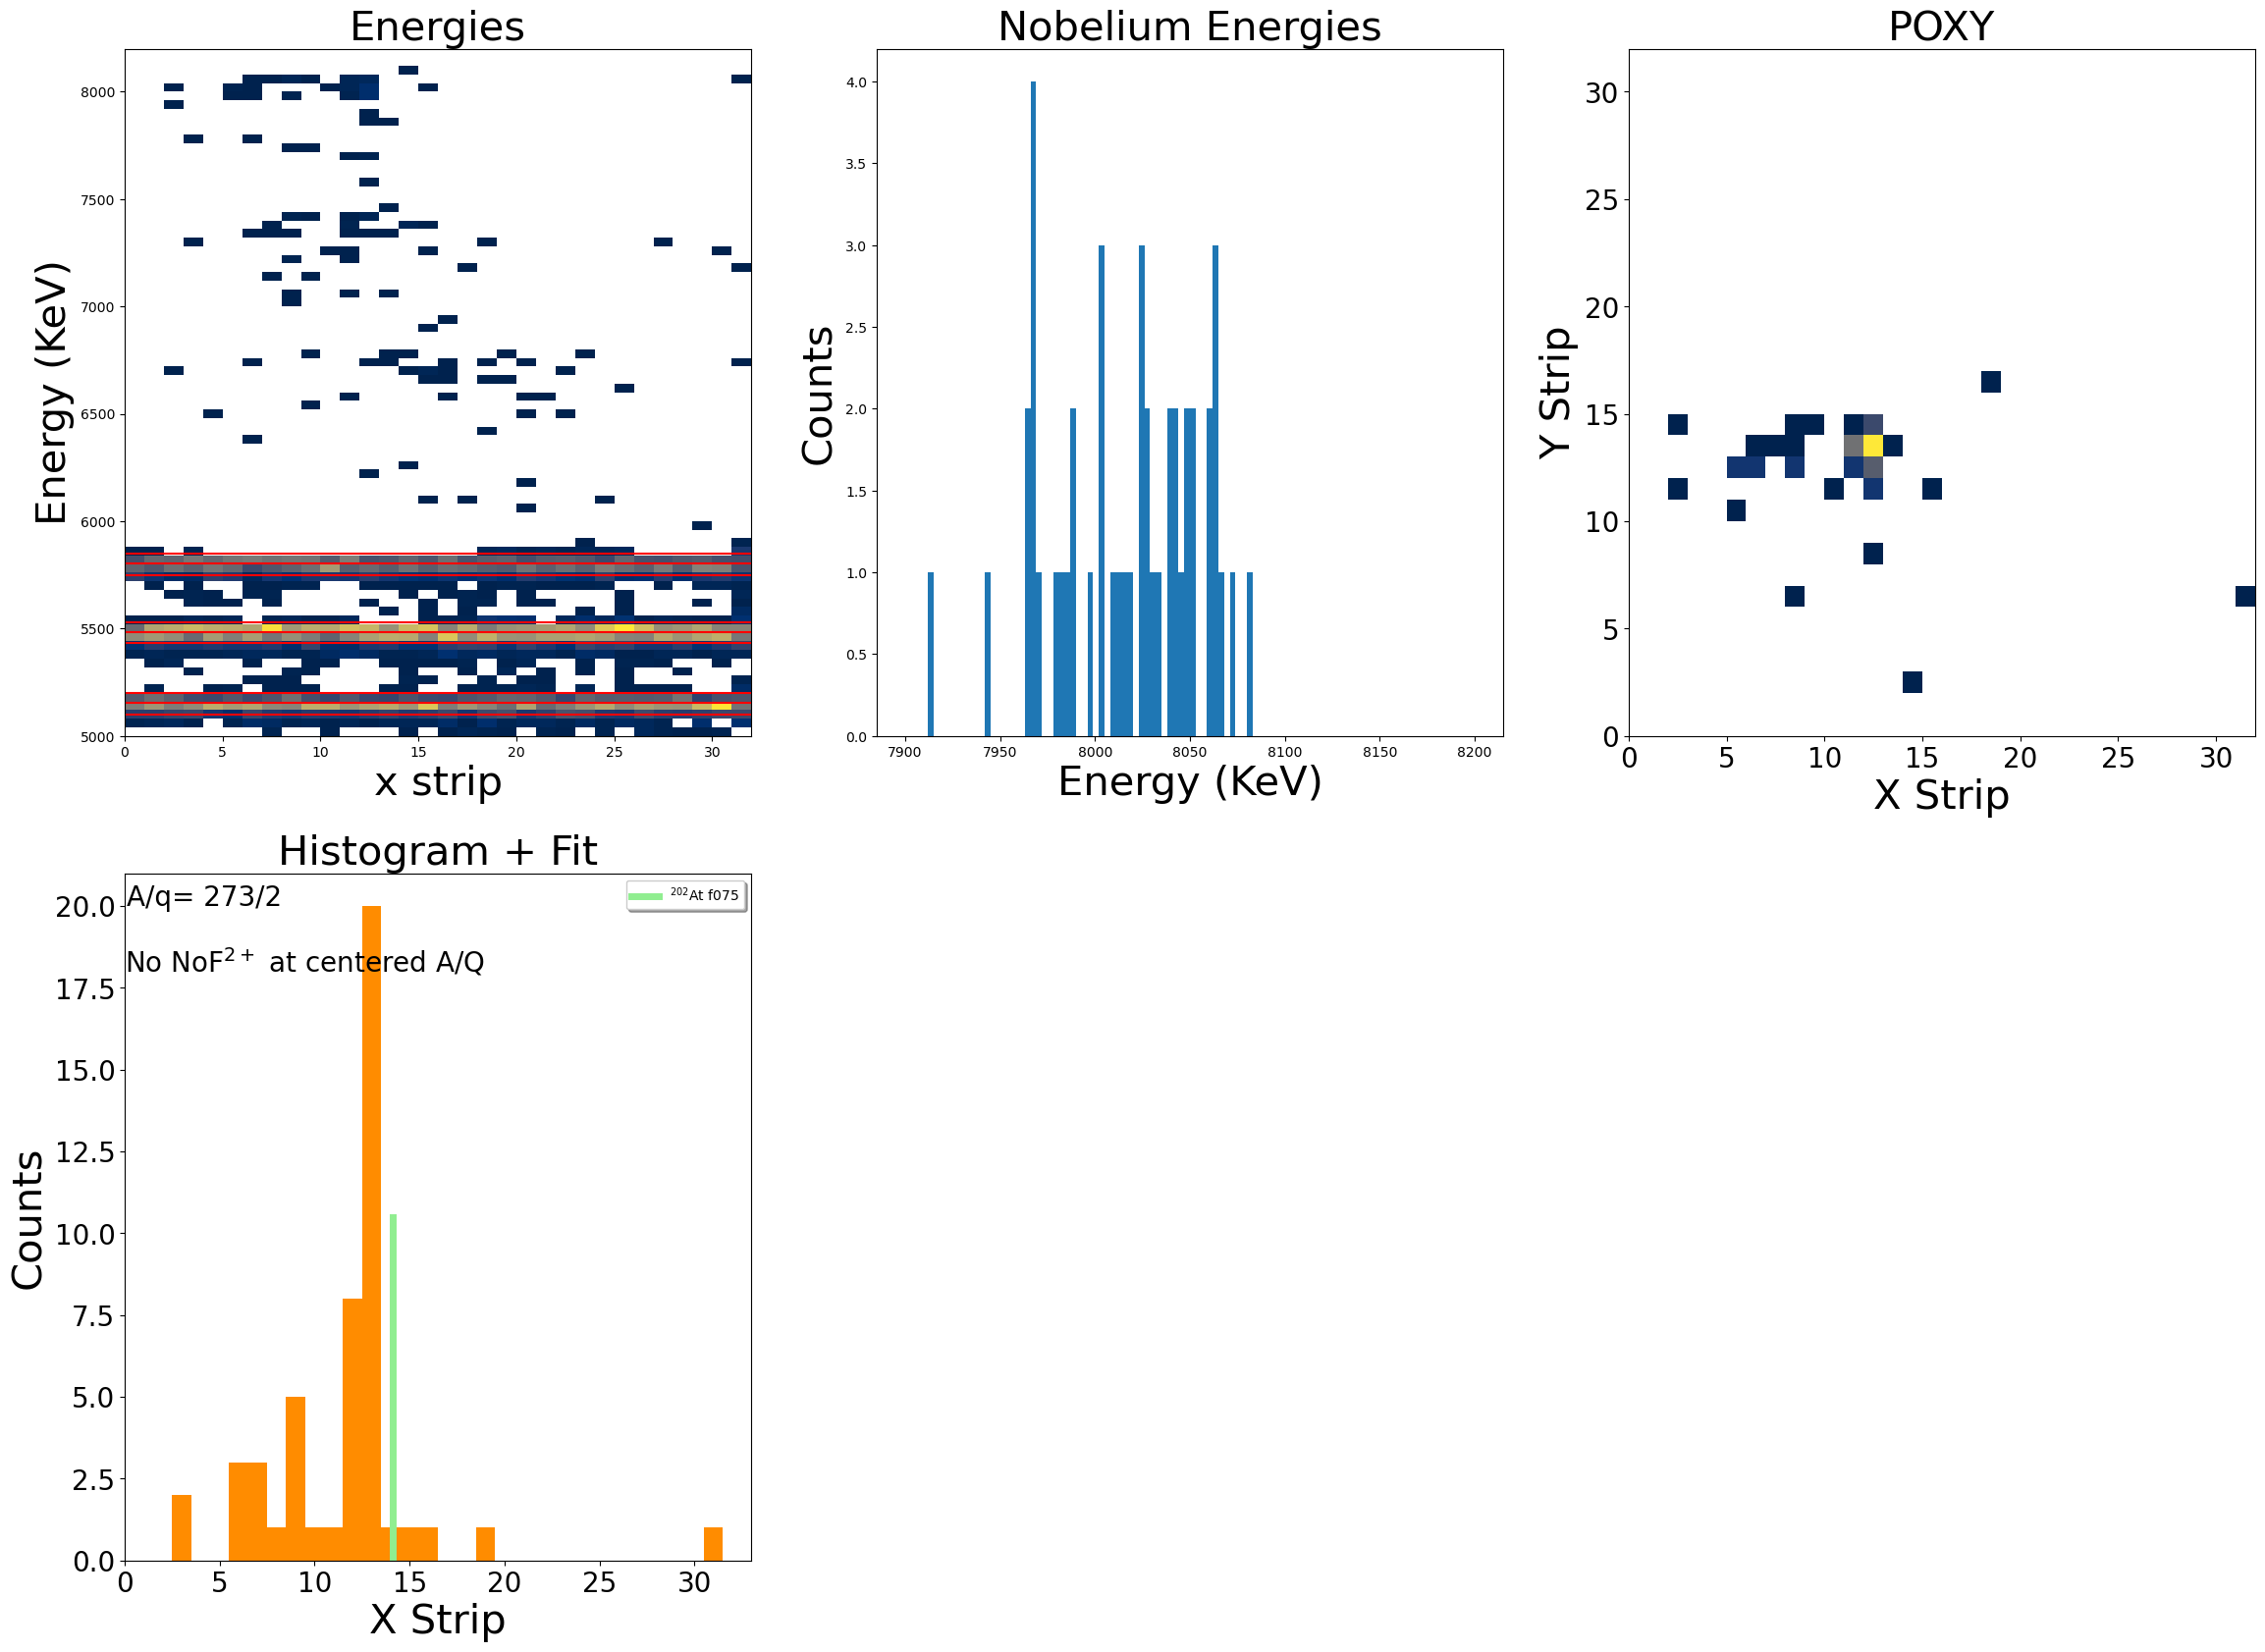

In [397]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)
df6_p1, t6_p1 = readDS('run231_081_output.txt', cal)



### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df6_p1['x'], df6_p1['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_6_p1 = df6_p1[(df6_p1['y'] >=0) & (df6_p1['y'] < 31) & (df6_p1['xE'] > 7800) & (df6_p1['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_6_p1['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_6_p1['x'], gates_6_p1['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram
counts,bins = np.histogram(gates_6_p1['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_6_p1['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,20, "A/q= 273/2", fontsize = 20)
plt.text(.01,18, "No NoF$^{2+}$ at centered A/Q", fontsize = 20)
plt.axvline(14.1,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f075')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.show()









# Bare Ions, no gas

### 254/1, no gas

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 61.32 (chi2/ndof = 2.9)    │              Nfcn = 89               │
│ EDM = 1.5e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

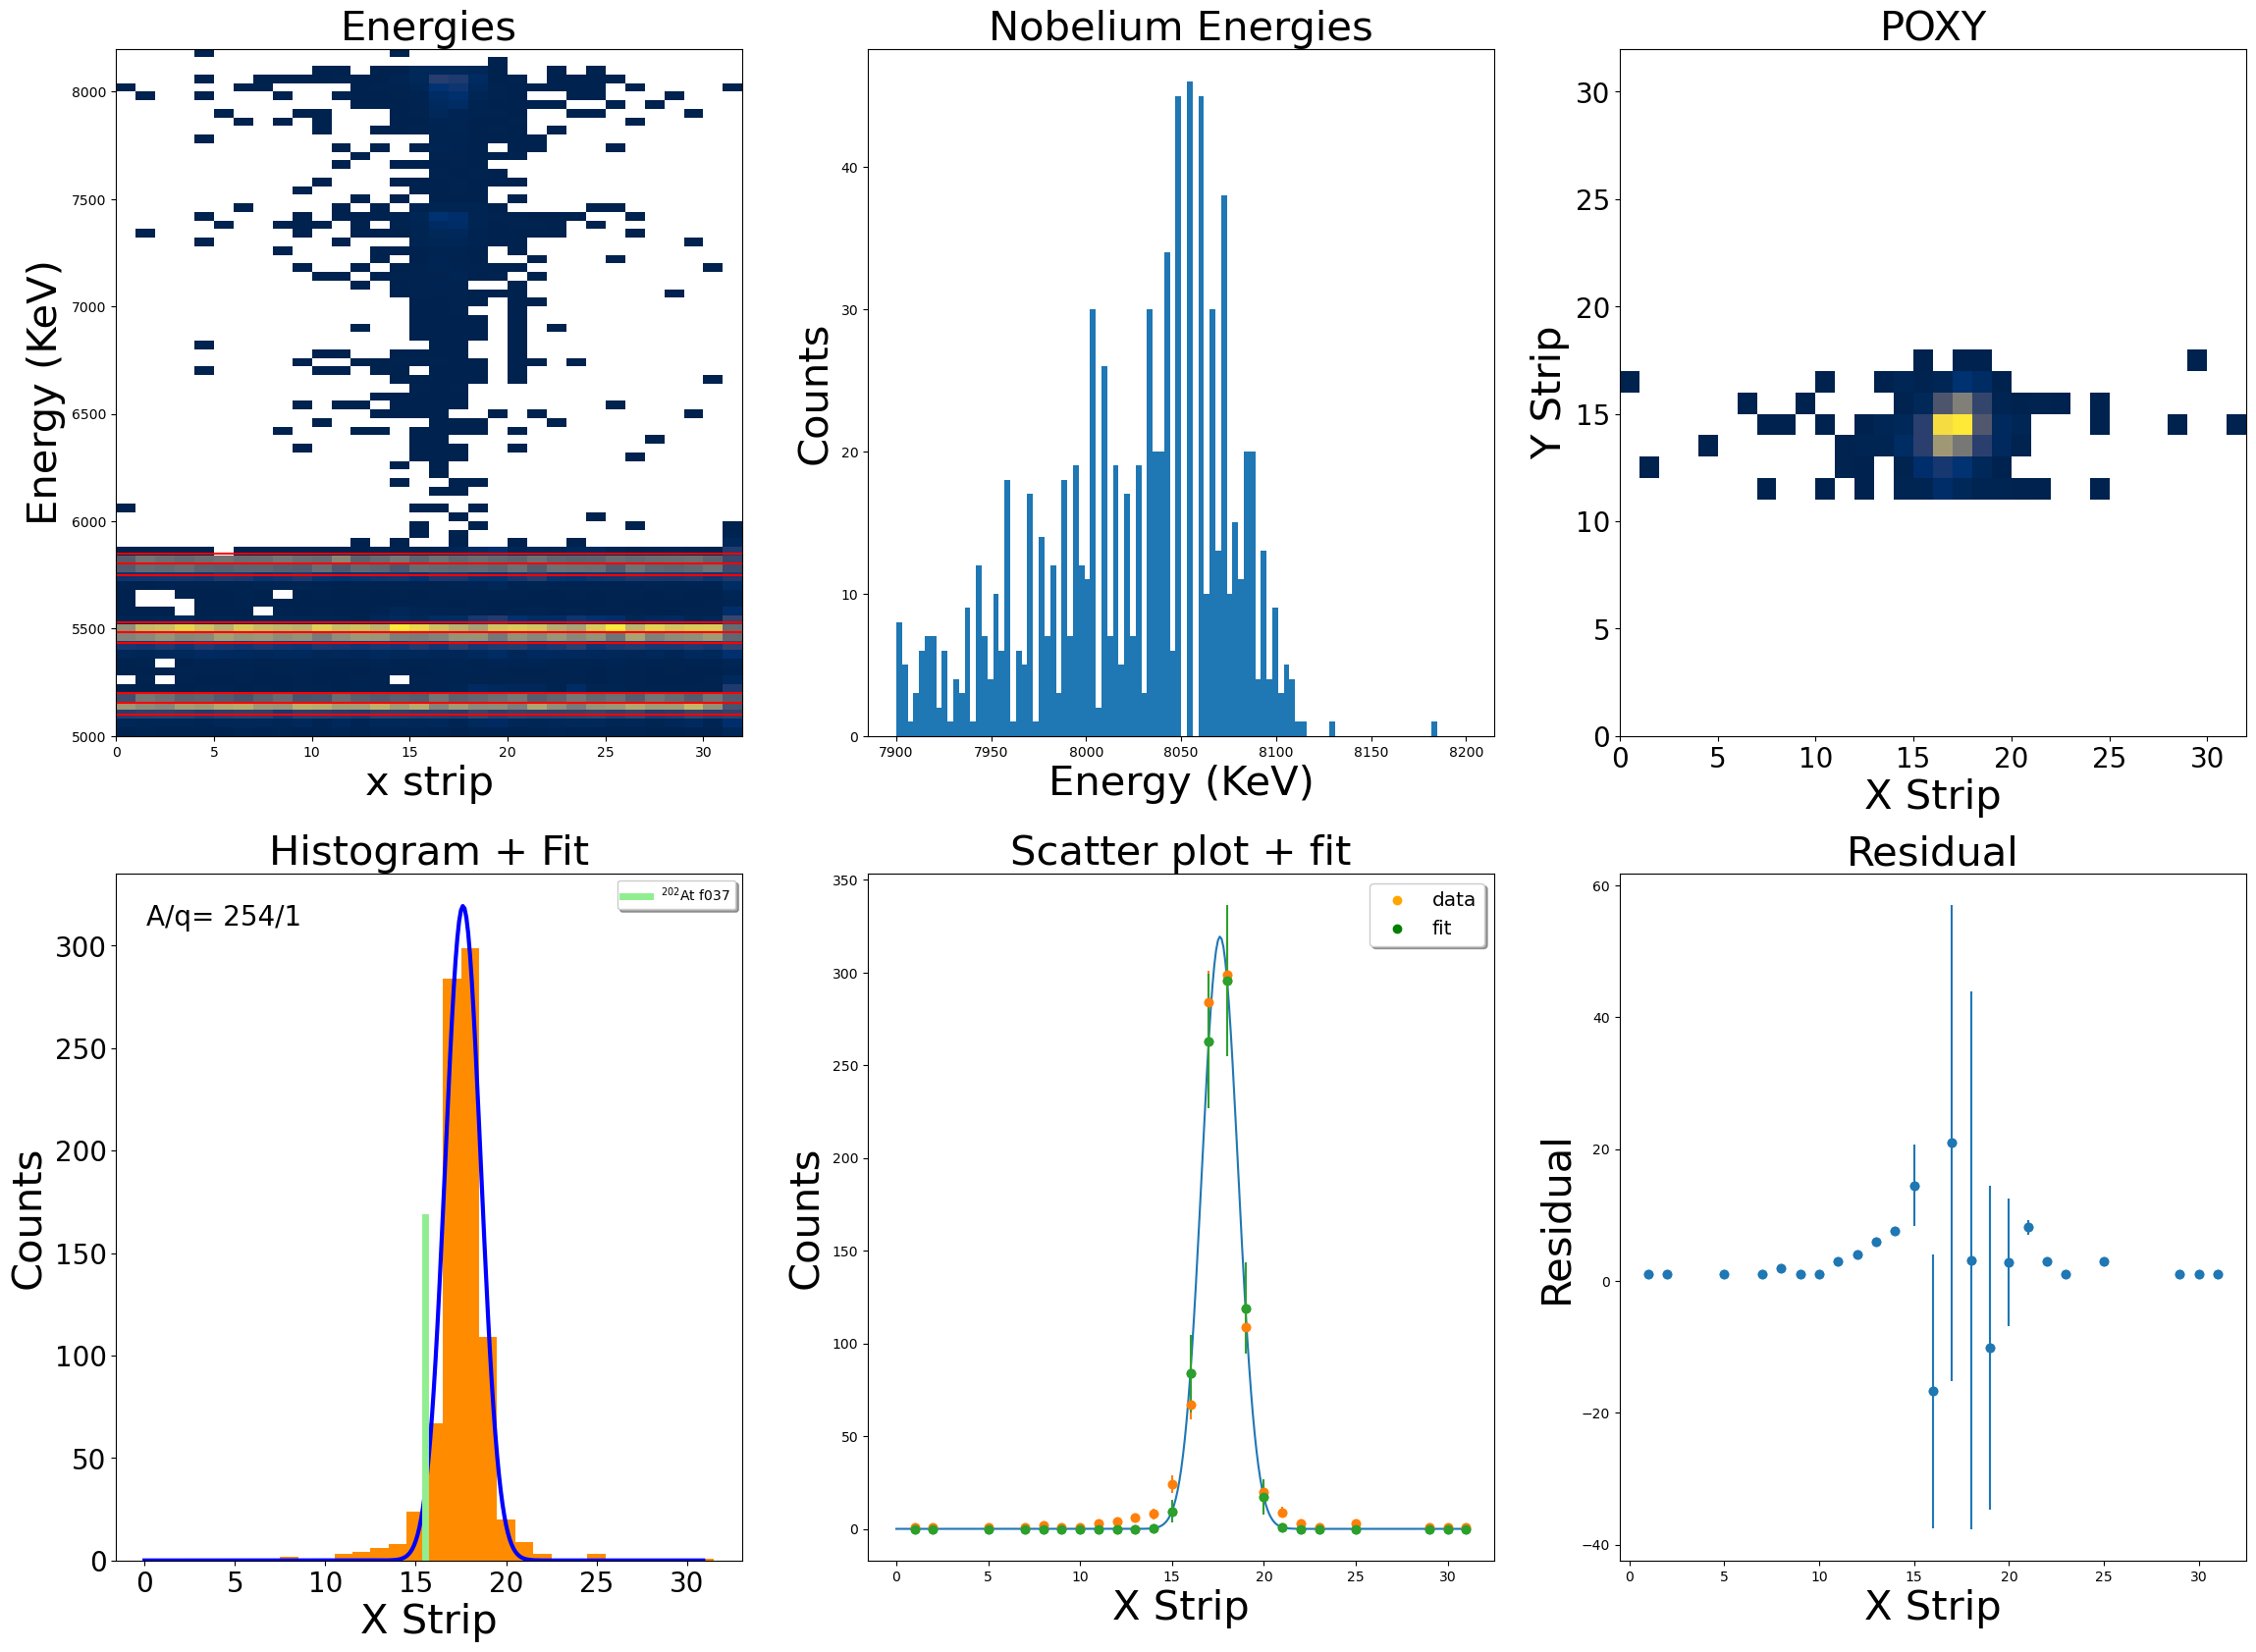

In [395]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df7_1, t7_1 = readDS('run231_033_output.txt', cal)
df7_2, t7_2 = readDS('run231_033_2_output.txt', cal)
df7 = pd.concat([df7_1,df7_2])
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df7['x'], df7['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_7 = df7[(df7['y'] >=11) & (df7['y'] < 18) & (df7['xE'] > 7900) & (df7['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_7['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_7['x'], gates_7['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram and fit
counts,bins = np.histogram(gates_7['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,onepeak)
m= minuit.Minuit(c,300,17,1.4)
m.limits=((None,None), (None,None),(0,None))
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
yy= onepeak(bins_,amp_1,cen_1,exp_1)
yy_=onepeak(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.hist(gates_7['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.text(.1,310, "A/q= 254/1", fontsize = 20)


### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [onepeak_error(newBins_change, p) for p in par_b]
error = 2.9*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)



### scatter plot
plt.subplot(2,3,5)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')


### Residual
residual = (newcounts - yy_)
plt.subplot(2,3,6)
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual)
plt.errorbar(newBins_change,residual, yerr=error, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual',fontsize = 30)

### How many counts in peak, area of the peak
area1=amp_1*exp_1/.3989


### Rutherford Number, East
dfRuth_7_1, t1Ruth_7_1 = readRuth('run231_033_output_Ruth.txt', 'ruthE')
dfRuth_7_2, t1Ruth_7_2 = readRuth('run231_033_2_output_Ruth.txt', 'ruthE')
dfRuth_7 = pd.concat([dfRuth_7_1,dfRuth_7_2])
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_7)))


### Counts per 1k ruth (CPR)
CPR_7 = area1/len(dfRuth_7)*1000
print(" Counts per 1k ruth (CPR_7) = %0.10f" % (CPR_7))



## 254/2, no gas

100
 Number of Rutherfords? = 36622.0000000000
 Counts per 1k ruth (CPR_8)= 2.7305990934


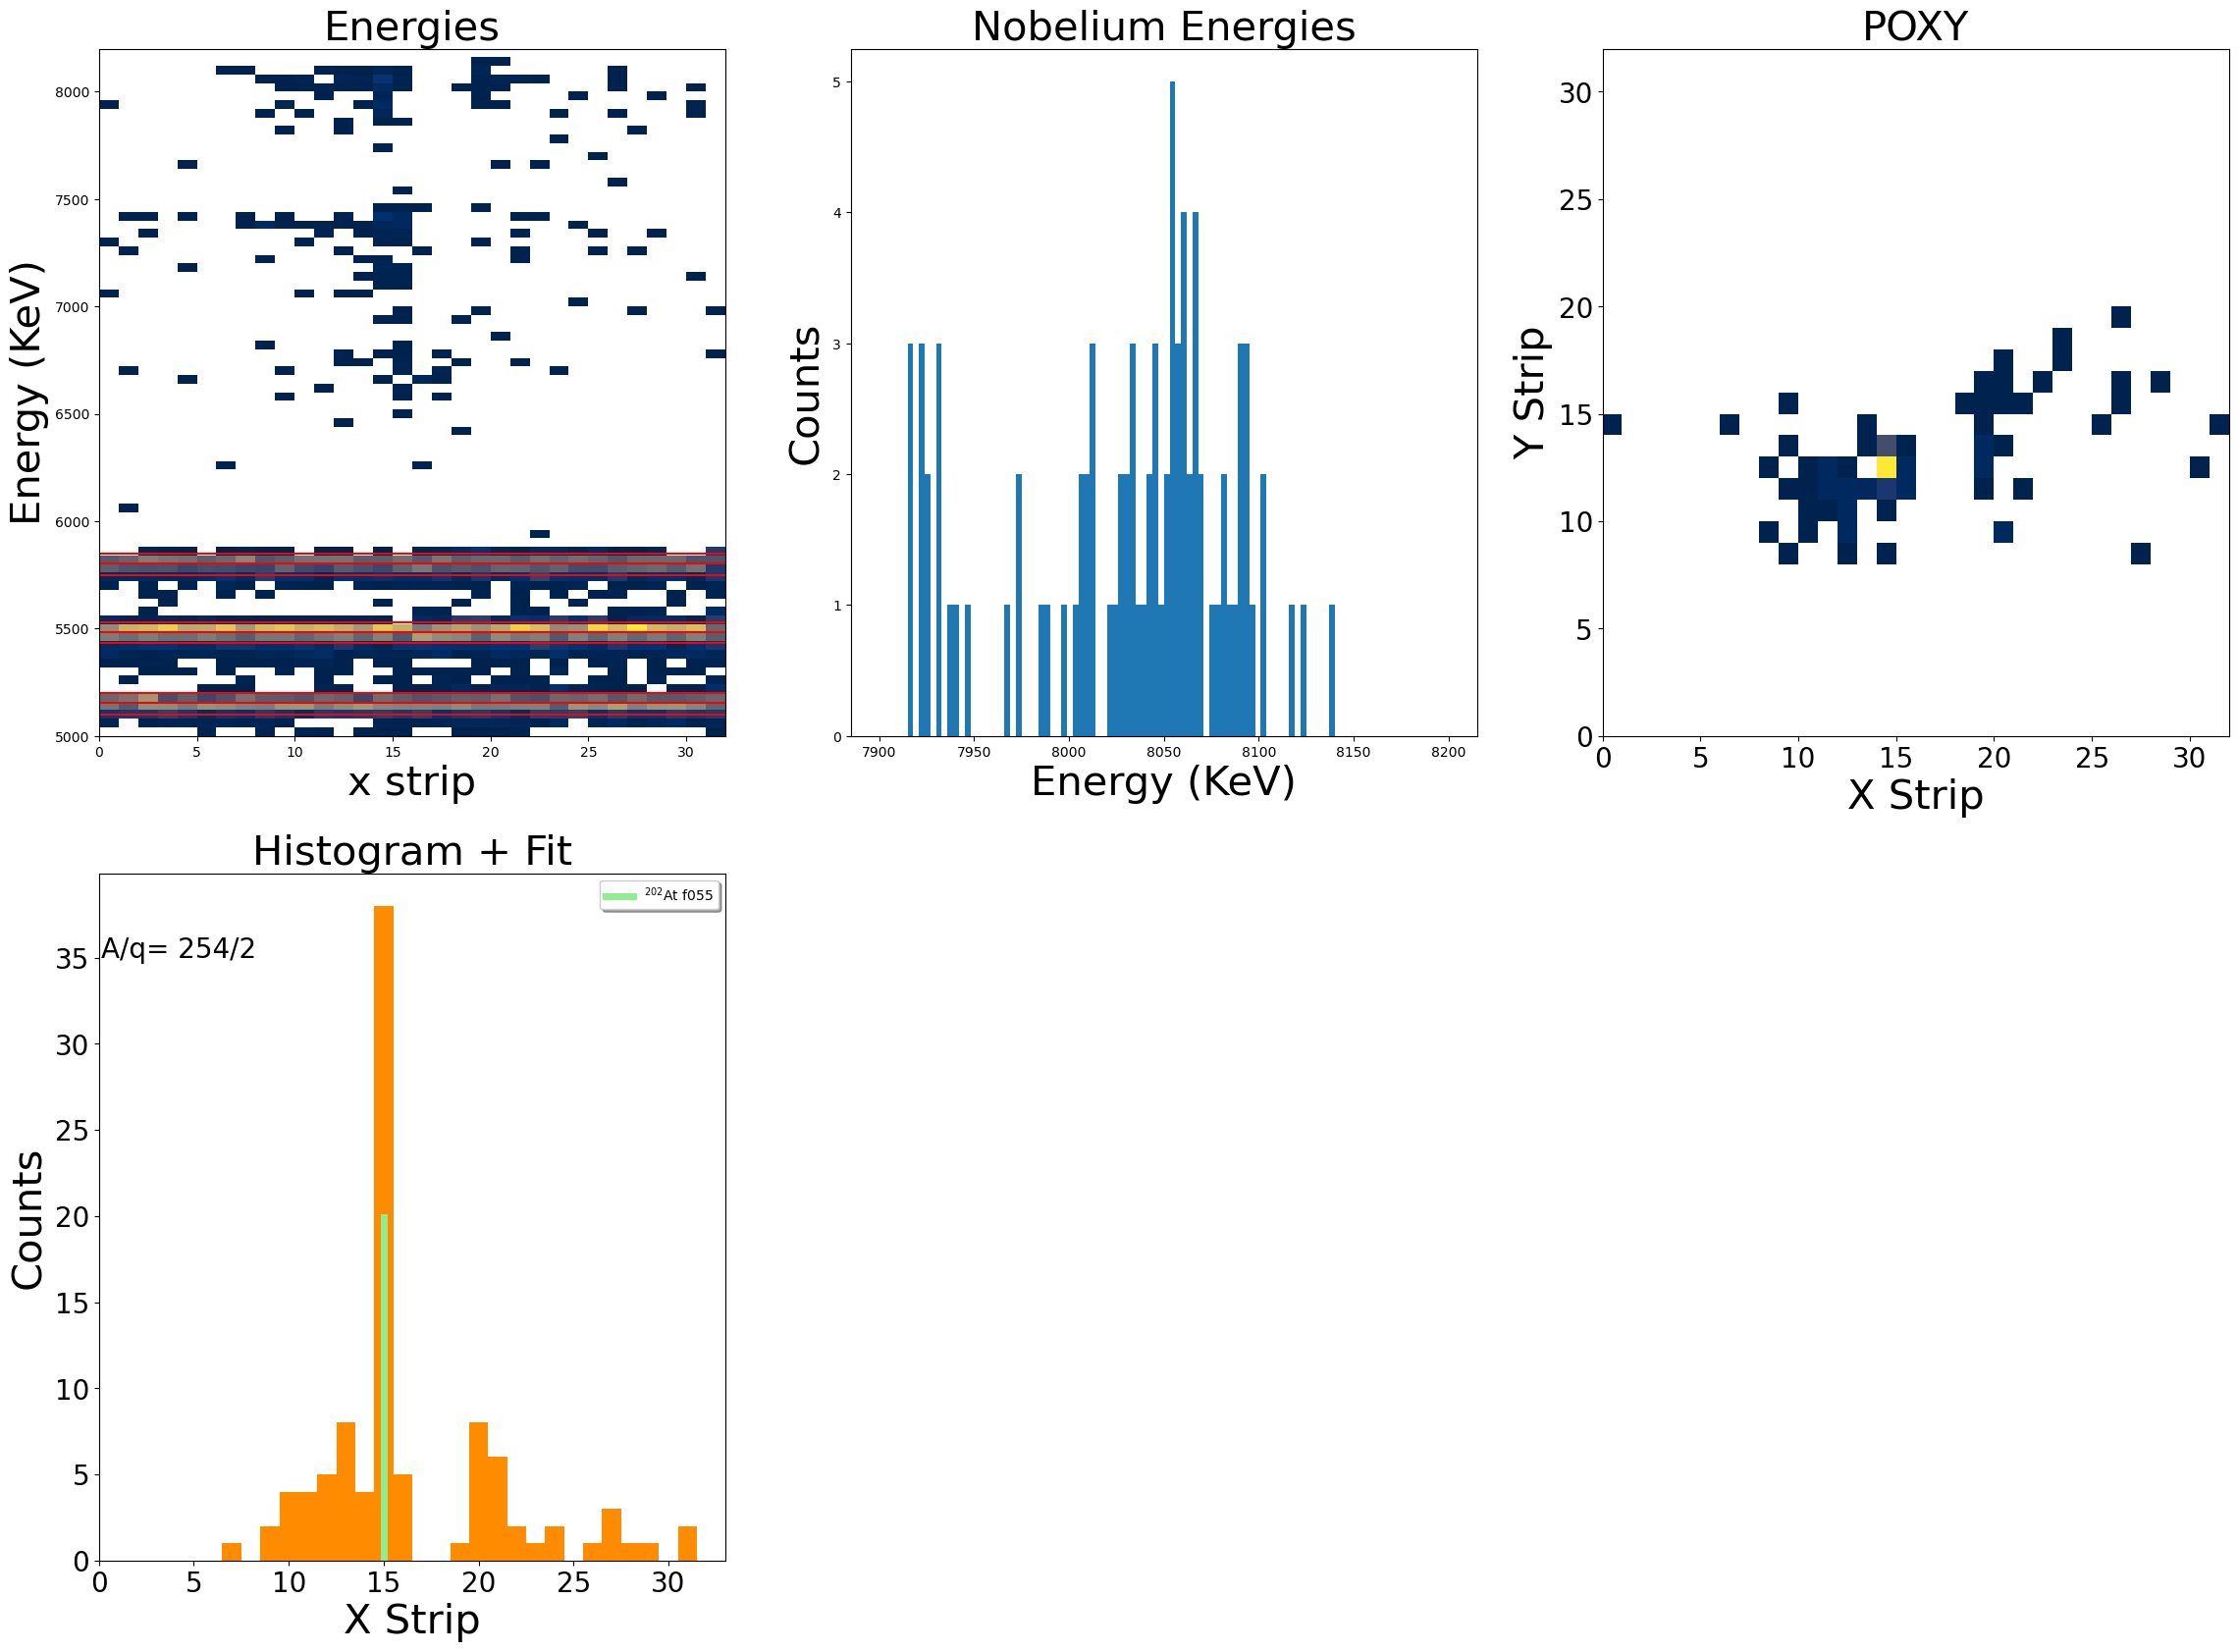

In [396]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df8, t1_8 = readDS('run231_052_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df8['x'], df8['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_8 = df8[(df8['y'] >=7) & (df8['y'] < 21) & (df8['xE'] > 7700) & (df8['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_8['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_8['x'], gates_8['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_8['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
#print(yy)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.hist(gates_8['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.axvline(15,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.text(.1,35, "A/q= 254/2", fontsize = 20)





### How many counts in peak, area of the peak
area1=sum(newcounts)
print (area1)


### Rutherford Number, East
dfRuth_8, t1Ruth_8 = readRuth('run231_052_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_8)))

### Counts per 1k ruth (CPR)
CPR_8 = area1/len(dfRuth_8)*1000
print(" Counts per 1k ruth (CPR_8)= %0.10f" % (CPR_8))



## F022, 254/2

100
 Number of Rutherfords? = 136778.0000000000
 Counts per 1k ruth = 0.7311117285


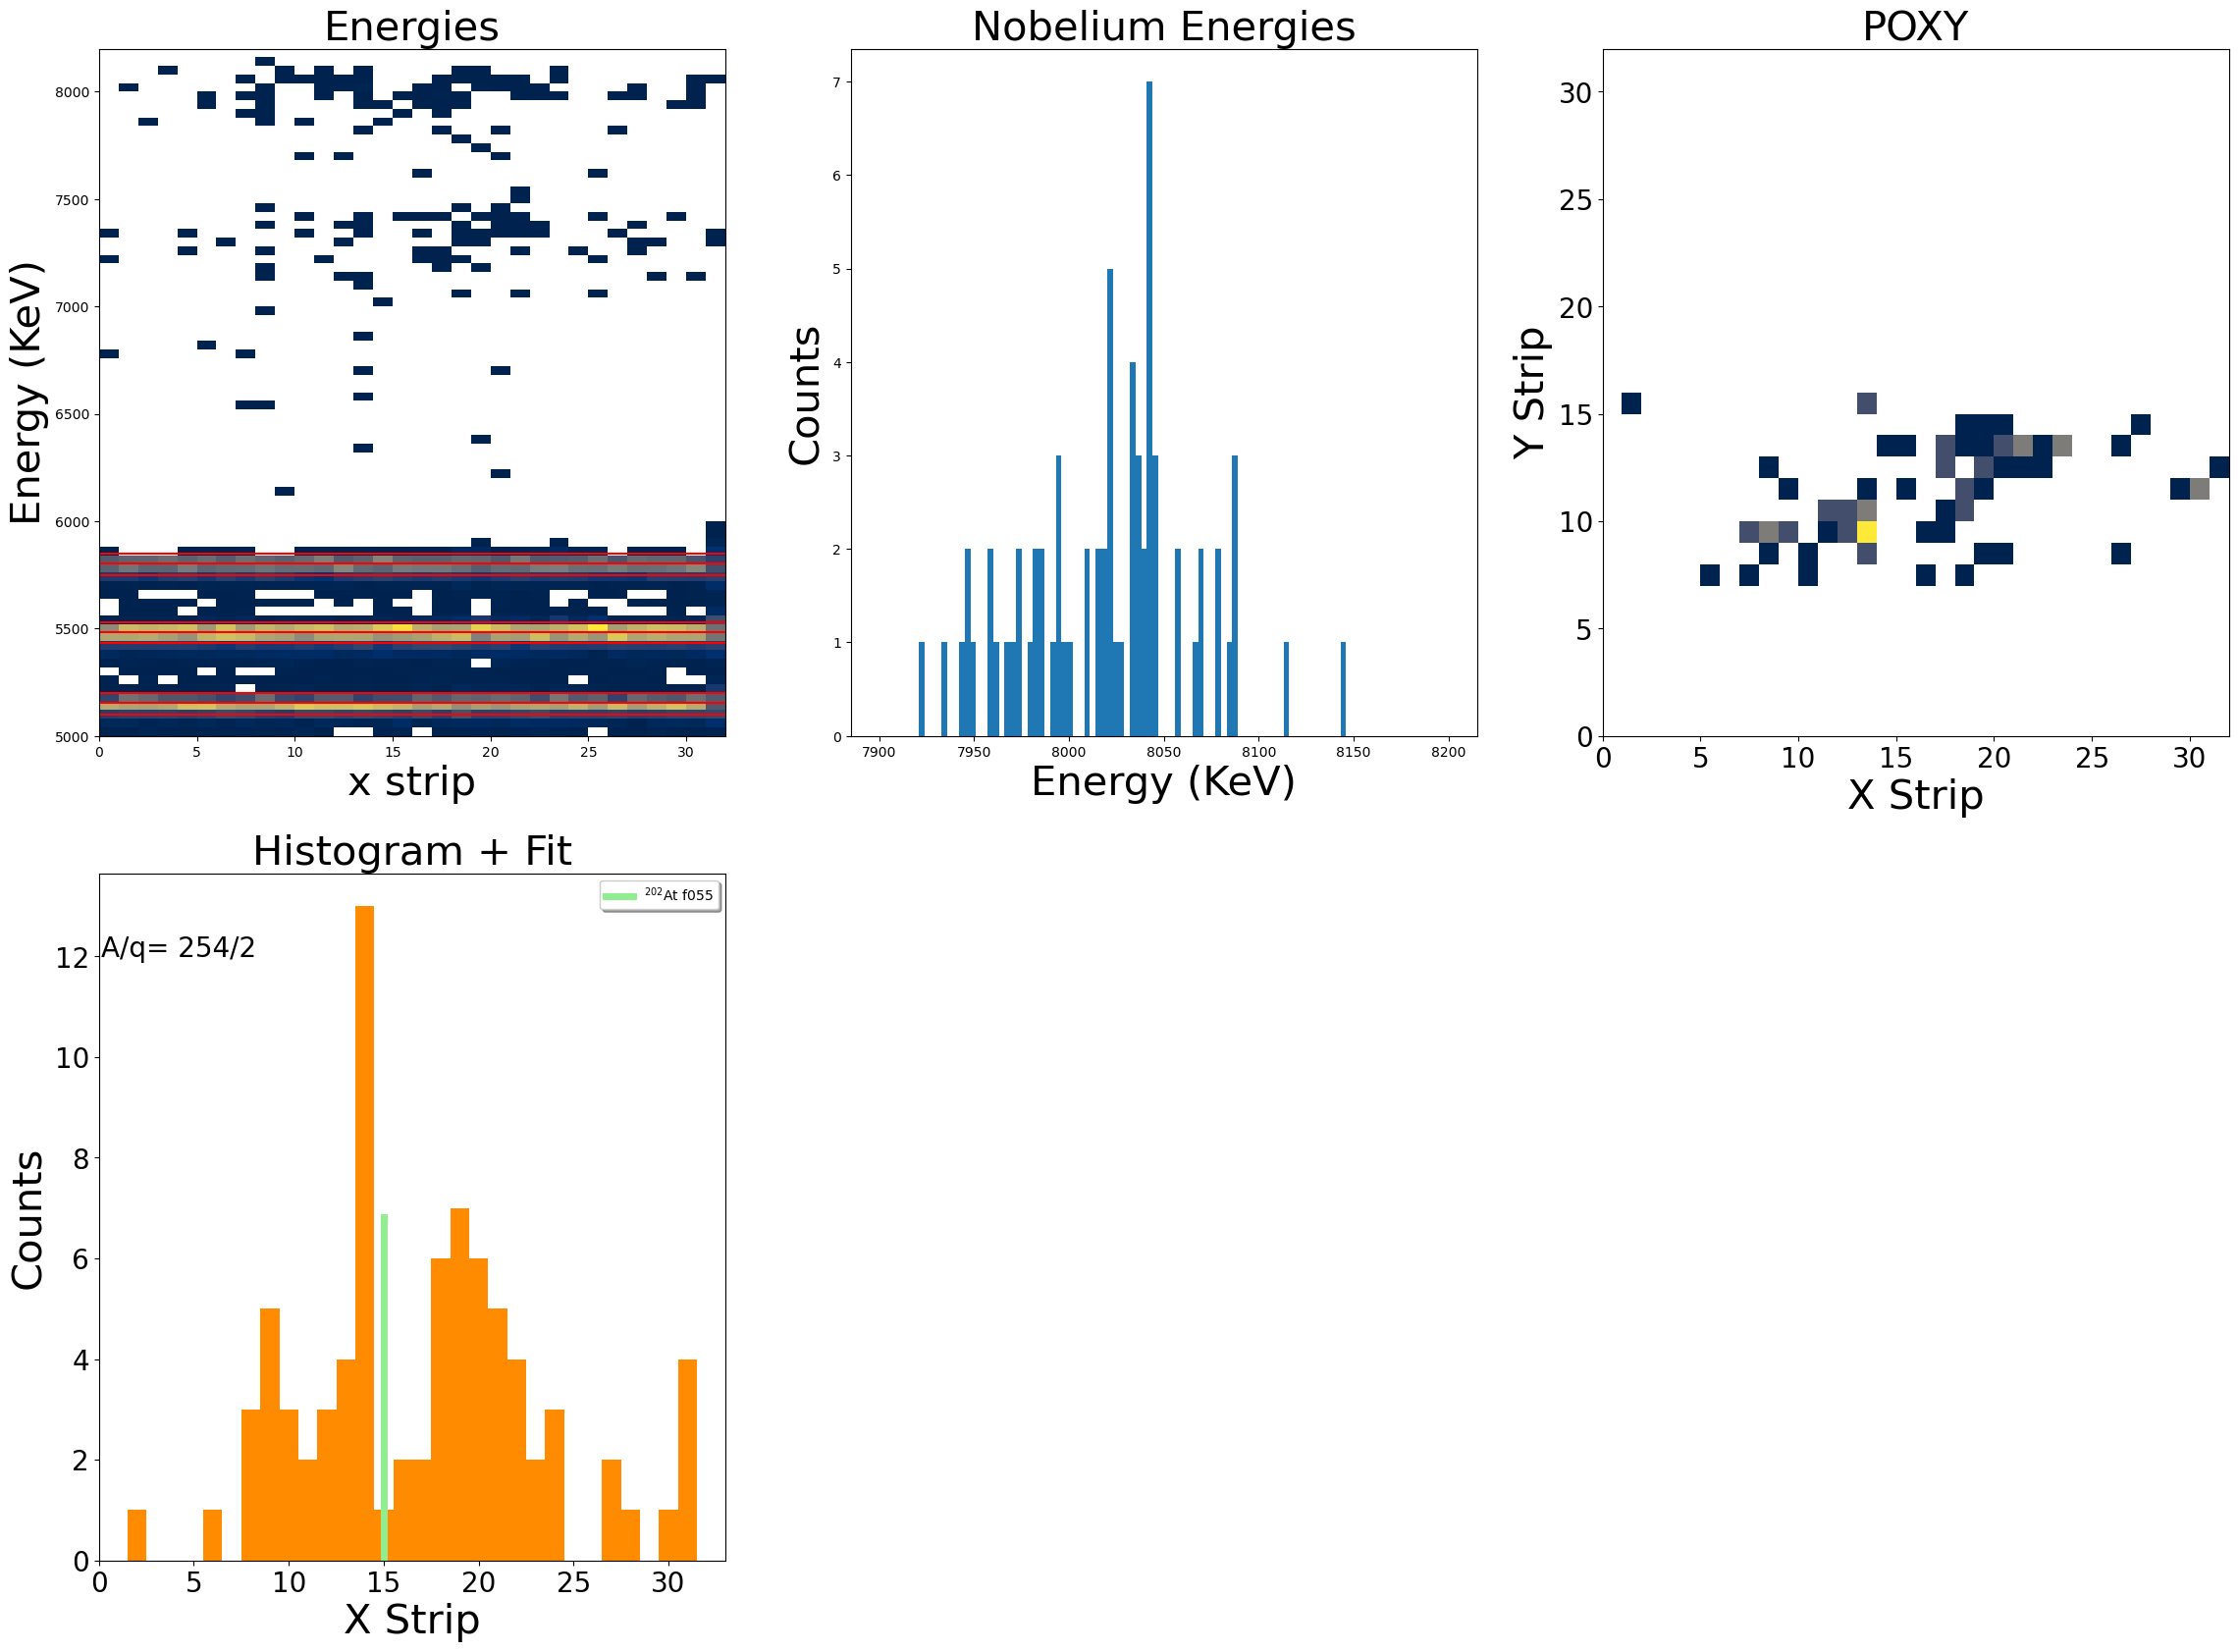

In [398]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df9_1, t9_1 = readDS('run231_022_output.txt', cal)
df9_2, t9_2 = readDS('run231_022_2_output.txt', cal)
df9 = pd.concat([df9_1,df9_2])
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df9['x'], df9['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_9 = df9[(df9['y'] >=7) & (df9['y'] < 16) & (df9['xE'] > 7700) & (df9['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_9['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_9['x'], gates_9['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_8['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
#print(yy)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.hist(gates_9['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.axvline(15,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.text(.1,12, "A/q= 254/2", fontsize = 20)





### How many counts in peak, area of the peak
area1=sum(newcounts)
print (area1)


### Rutherford Number, East
dfRuth_9_1, t1Ruth_9_1 = readRuth('run231_022_output_Ruth.txt', 'ruthE')
dfRuth_9_2, t1Ruth_9_2 = readRuth('run231_022_output_2_Ruth.txt', 'ruthE')
dfRuth_9 = pd.concat([dfRuth_9_1,dfRuth_9_2])


print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_9)))

### Counts per 1k ruth (CPR)
CPR_9 = area1/len(dfRuth_9)*1000
print(" Counts per 1k ruth = %0.10f" % (CPR_9))



## F030, 254/2

358
 Number of Rutherfords? = 177233.0000000000
 Counts per 1k ruth (CPR_8)= 2.0199398532


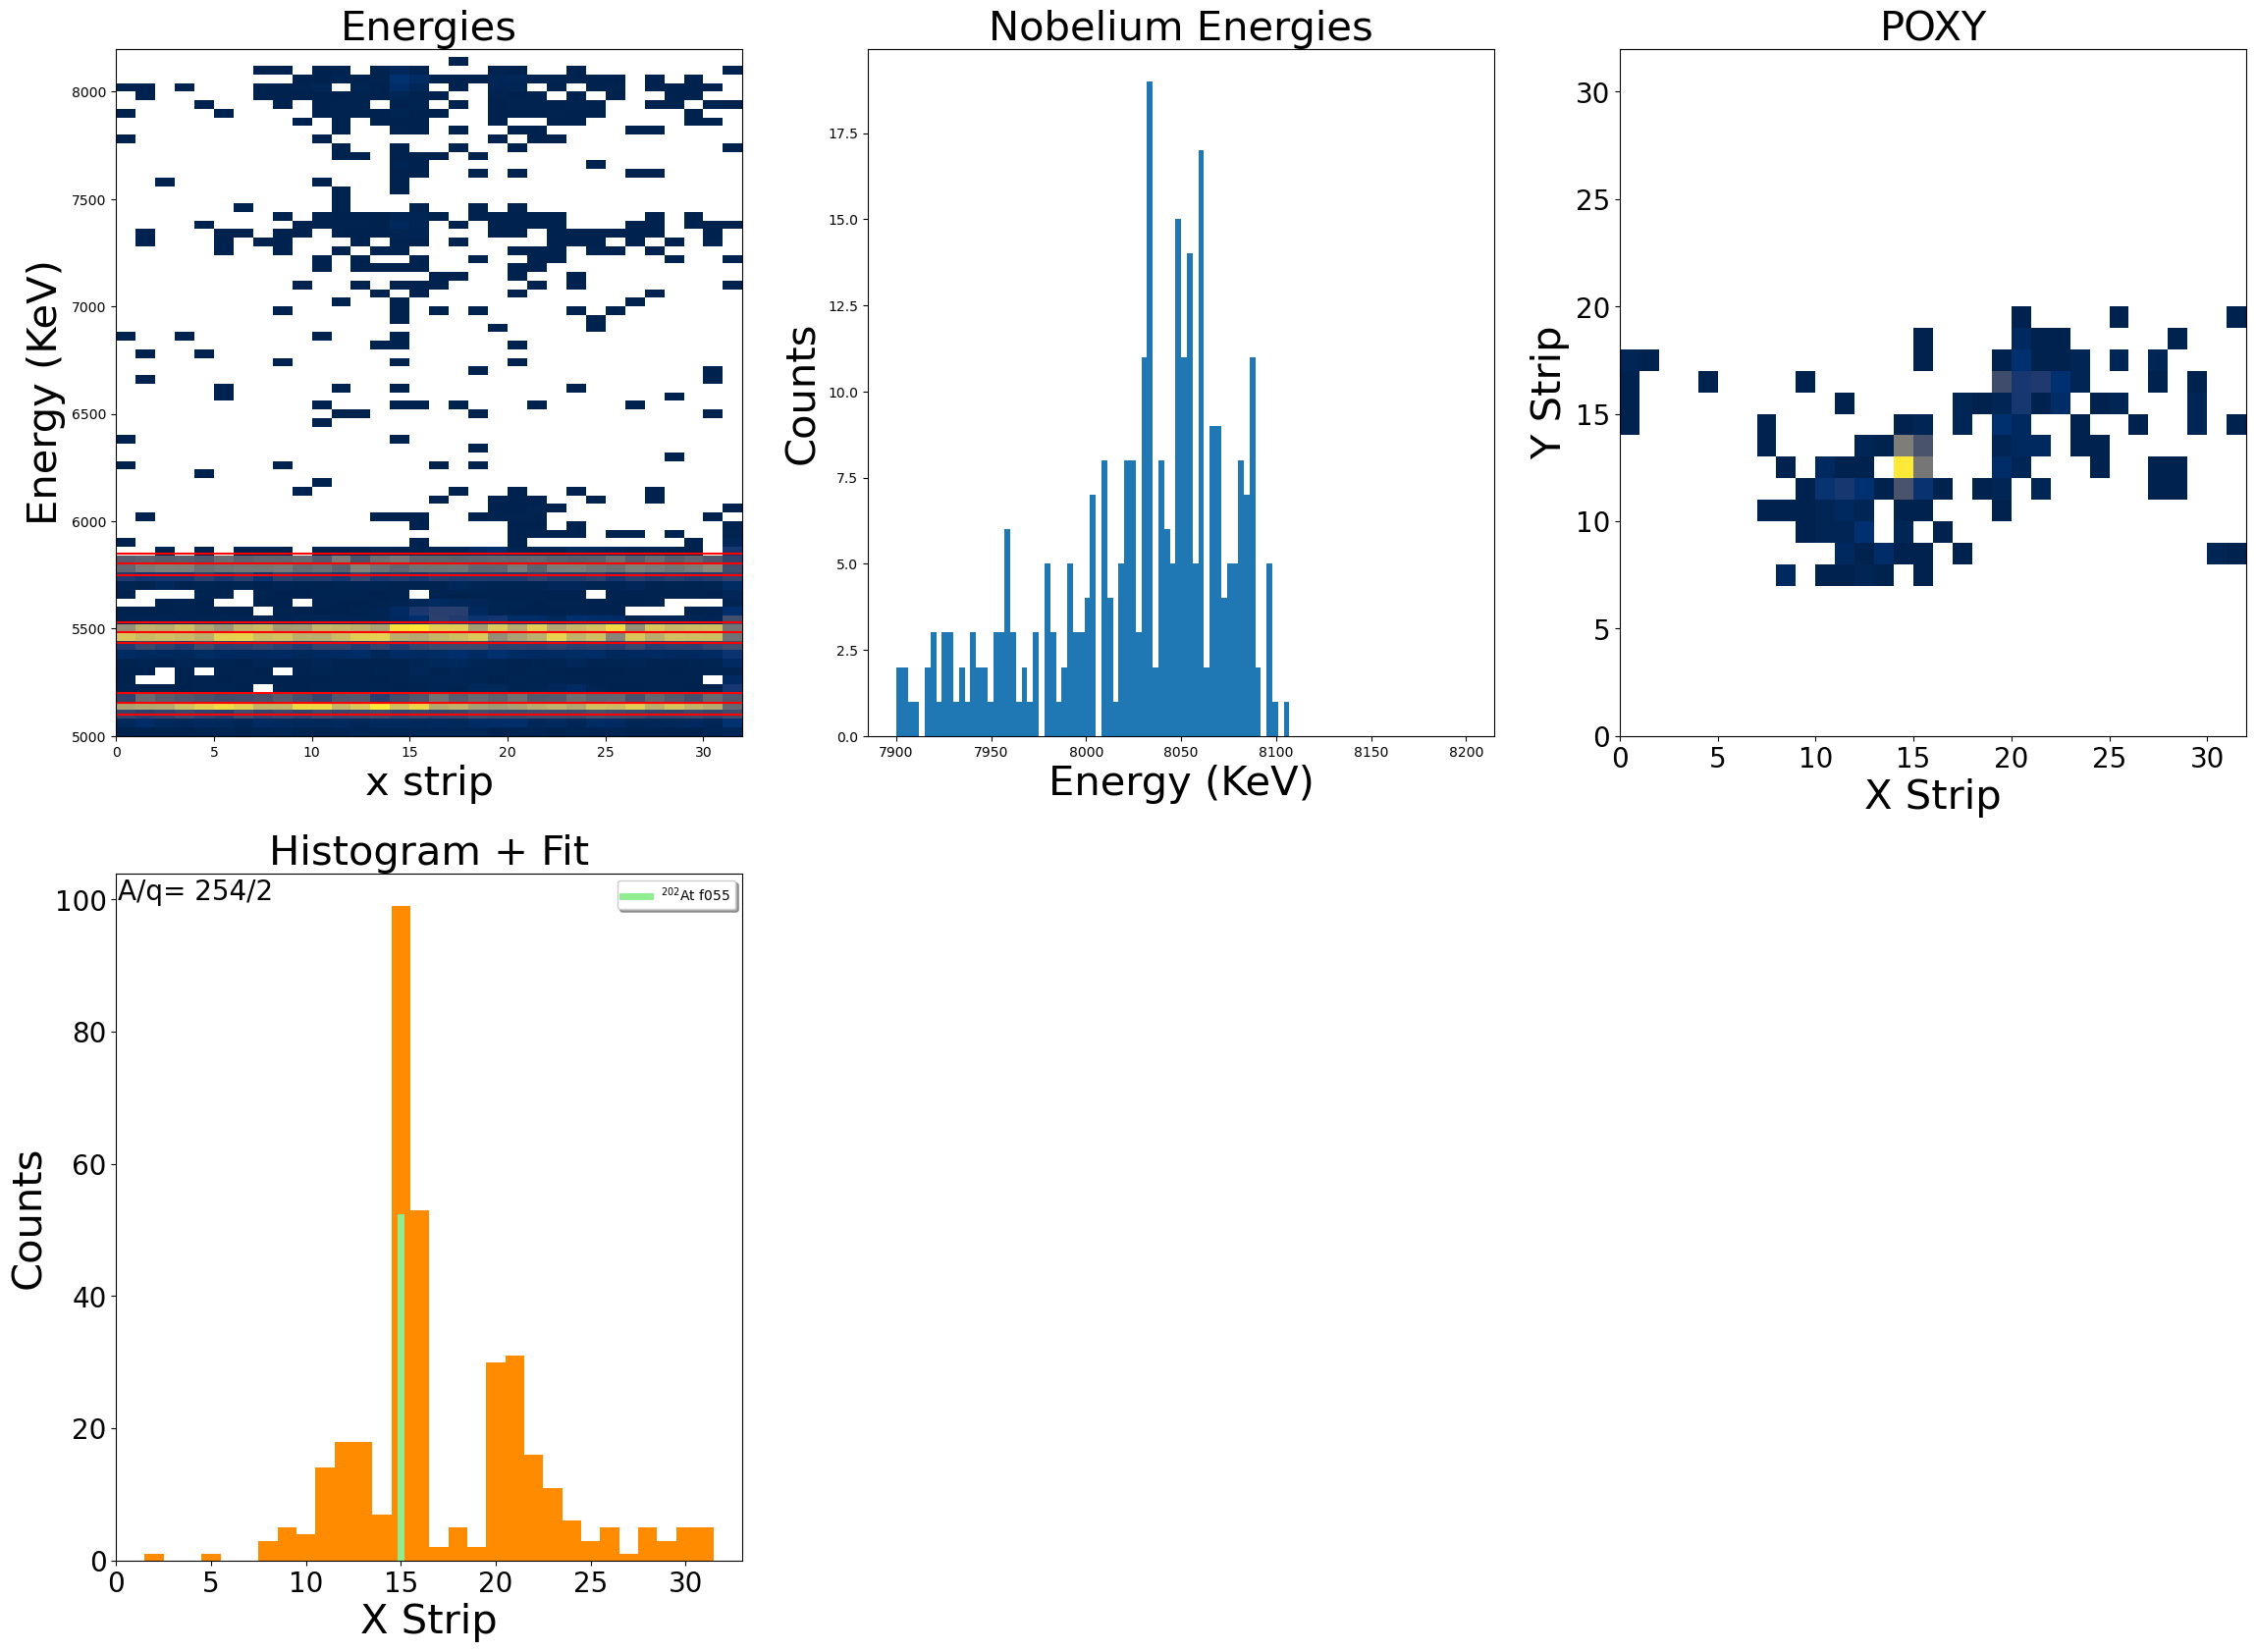

In [399]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df10, t1_10 = readDS('run231_030_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df10['x'], df10['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_10 = df10[(df10['y'] >=7) & (df10['y'] < 21) & (df10['xE'] > 7700) & (df10['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_10['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_10['x'], gates_10['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram
counts,bins = np.histogram(gates_10['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
#print(yy)
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.hist(gates_10['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.axvline(15,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.text(.1,100, "A/q= 254/2", fontsize = 20)





### How many counts in peak, area of the peak
area1=sum(newcounts)
print (area1)


### Rutherford Number, East
dfRuth_10, t1Ruth_10 = readRuth('run231_030_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_10)))

### Counts per 1k ruth (CPR)
CPR_10 = area1/len(dfRuth_10)*1000
print(" Counts per 1k ruth (CPR_8)= %0.10f" % (CPR_10))

